# Problem Definition

Clearly define the objective (classification or regression) and business goals. SMART objectives

Prediction of a district’s median housing price. This model can be used for investment analysis to determine whether it is worth investing in a given area or not.

Performance Measures

Root Mean Square Error (RMSE) It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

Mean Absolute Error (MAE)


# Imports

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist
from yellowbrick.target import ClassBalance
from sklearn.preprocessing import StandardScaler
# !pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [6]:
pd.set_option('display.max_columns', None)

In [ ]:
# pd.set_option('display.max_rows', None)

# Data Read

In [132]:
def read():
    df = pd.read_csv("../data/interim/all_cities_combined_anonymized_.csv", index_col=0)
    return df
df = read()

# Initial Data Cleaning and Train/Test Splitting

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47973 entries, 0 to 47975
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   estate              47973 non-null  object 
 1   transaction         47973 non-null  object 
 2   areaInSquareMeters  47973 non-null  float64
 3   roomsNumber         47973 non-null  object 
 4   dateModified        47973 non-null  object 
 5   dateOfCreation      47973 non-null  object 
 6   location            47935 non-null  object 
 7   price               43891 non-null  float64
 8   market              47973 non-null  object 
 9   advertiserType      47973 non-null  object 
 10  advertType          47973 non-null  object 
 11  buildYear           40653 non-null  float64
 12  buildingFloorsNum   45642 non-null  float64
 13  cityId              47973 non-null  int64  
 14  buildingOwnership   40130 non-null  object 
 15  buildingType        37172 non-null  object 
 16  construct

missing values - location, buildYear, buildingsFloorsNum, buildingOwnership, buildingType, constructionStatus, extrasTypes outdoor heating freeFrom

7 features are numerical, 15 categorical

In [5]:
# Checking categorical features, selecting those that can be deleted

# Checking categorical columns with <8 variables:
columns = df.select_dtypes(include=['object'])
for i in columns:
    values_dict = {}
    unique_values = df[i].value_counts()
    if len(unique_values) < 8:
        # values_dict.
        print(unique_values)

estate
FLAT    47973
Name: count, dtype: int64
transaction
SELL    47973
Name: count, dtype: int64
market
SECONDARY    27643
PRIMARY      20330
Name: count, dtype: int64
advertiserType
business    43329
private      4644
Name: count, dtype: int64
advertType
AGENCY            34971
DEVELOPER_UNIT     7796
PRIVATE            5206
Name: count, dtype: int64
buildingOwnership
['full_ownership']       37020
['limited_ownership']     2873
['share']                  157
['usufruct']                80
Name: count, dtype: int64
buildingType
['block']        20632
['apartment']    10995
['tenement']      4736
['ribbon']         391
['house']          277
['infill']          95
['loft']            46
Name: count, dtype: int64
constructionStatus
['ready_to_use']     18758
['to_completion']    17874
['to_renovation']     2769
Name: count, dtype: int64
outdoor
balcony    29078
garden      3401
terrace     2350
Name: count, dtype: int64
heating
urban          28026
gas             3370
other          

In [133]:
# Delete unnecessary data
def drop_data(df):
    # Additional step only for training the model. Delete NA price since this value we're going to predict, around 8-9% of initial data will be lost
    df = df.dropna(axis=0, subset=["price"], ignore_index=False)

    # Dropping house building types, since we are suppose to only predict flats
    df = df.drop(df[df["buildingType"] == "['house']"].index)

    # Dropping features that won't contribute to the test, either one value for whole dataset, too many categories, categories hard to fil NaNs or too many NaN values
    df = df.drop(columns=["estate", "transaction", "dateModified", "dateOfCreation", "cityId", "heating", "extrasTypes", "freeFrom"], axis=1)
    
    return df

df = drop_data(df)

In [134]:
# Removing [''] characters from categrical values 

regex_list = ["buildingOwnership", "buildingType", "constructionStatus"]

def cleaning_data(df):
  for i in regex_list:
    df[i] = df[i].replace([r"\[", r"\]", r"\'"], "", regex=True)
  return df

df = cleaning_data(df)


We know that in scraping stage all duplicates were removed based on offers id - no need to remove duplicates

Based on data understanding we know that location is a very important factor for flats price, therefore it will be extracted from location features and used for strattified shuffle split

In [135]:
# Extracting location from str 

def split_location(df, column_name="location"):
  dfLocation = df["location"].str.split(", ", expand=True)
  df["subdivision"] = dfLocation[0]
  df["district"] = dfLocation[1]
  df["city"] = dfLocation[2]
  df.drop(columns = ["location"], inplace = True)
  # List of cities to keep
  cities_to_keep = ["Wrocław", "Warszawa", "Poznań", "Kraków", "Łódź"]
  # Filter the DataFrame to include only rows with cities in the list since we're building model to predict price in 5 biggest Poland cities
  df = df[df["city"].isin(cities_to_keep)]
  return df

df = split_location(df)

In [136]:
# Add 'stratified' column for spliting purpose
def stratify(df):
    df["price_cat"] = pd.qcut(df["price"], q=3, labels=False)
    df["areaInSquareMeters_cat"] = pd.qcut(df["areaInSquareMeters"], q=3, labels=False)
    df["buildYear_cat"] = pd.qcut(df["buildYear"], q=3, labels=False)
    df["stratified"] = df["price_cat"].astype(str) + "_" + df["areaInSquareMeters_cat"].astype(str) + "_" + df["buildYear_cat"].astype(str) + "_" + df["city"].astype(str)
    
    strat_counts = df['stratified'].value_counts()
    one_value_strat = strat_counts[strat_counts == 1].index.tolist()
    
    for category in one_value_strat:
        df.loc[df['stratified'] == category, 'stratified'] = 'other'
    
    return df

# Splits the dataset into stratified train and test sets based on the 'stratified' column
def split(df):
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

  for train_index, test_index in split.split(df, df["stratified"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

  columns_to_drop = ["stratified", "price_cat", "areaInSquareMeters_cat", "buildYear_cat"]
  strat_train_set = strat_train_set.drop(columns=columns_to_drop)
  strat_test_set = strat_test_set.drop(columns=columns_to_drop)
  # df = df.drop(columns=columns_to_drop)

  return strat_train_set, strat_test_set#, df

In [ ]:
strat_train_set, strat_test_set = split(stratify(df)) # df For visualization purpose
df = df.drop(columns=["stratified", "price_cat", "areaInSquareMeters_cat", "buildYear_cat"])

# EDA

## Visualization of categotical values

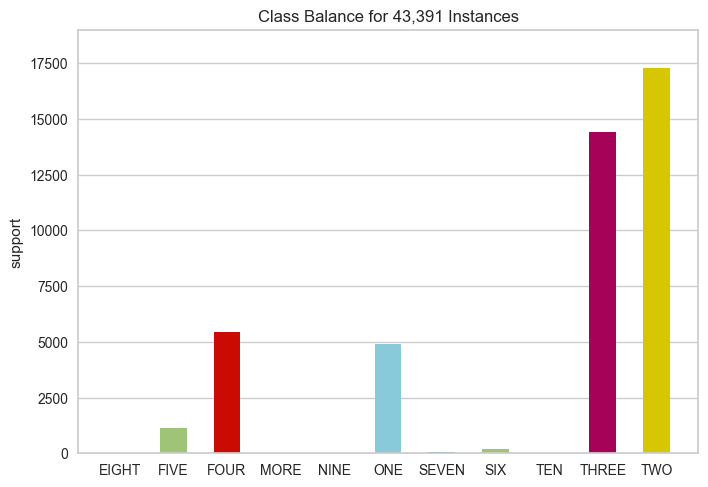

Percentage of 2 and 3 rooms: 72.99%


In [127]:
# Rooms distribution

visualizer = ClassBalance()   # Initialize the ClassBalance visualizer
visualizer.fit(df['roomsNumber'])  # Fit the visualizer on a particular feature (in this case, 'roomsNumber')
visualizer.show()  # Display the class distribution of that feature

percentage = ((df["roomsNumber"] == "THREE").sum() + (df["roomsNumber"] == "TWO").sum()) / len(df) * 100
print(f"Percentage of 2 and 3 rooms: {percentage:.2f}%")

Vast majority is categorized as a 2 or 3 rooms flats, over 70%

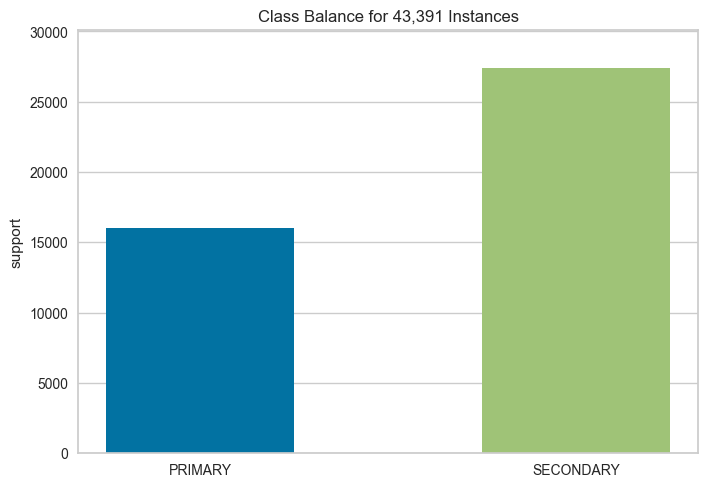

Percentage of 'SECONDARY' market: 63.11%


In [126]:
# Market ditribution
 
visualizer = ClassBalance()
visualizer.fit(df['market'])
visualizer.show()

percentage_secondary = (df["market"] == "SECONDARY").sum() / len(df) * 100
print(f"Percentage of 'SECONDARY' market: {percentage_secondary:.2f}%")

Over 60% of flats belongs to a secondary market.

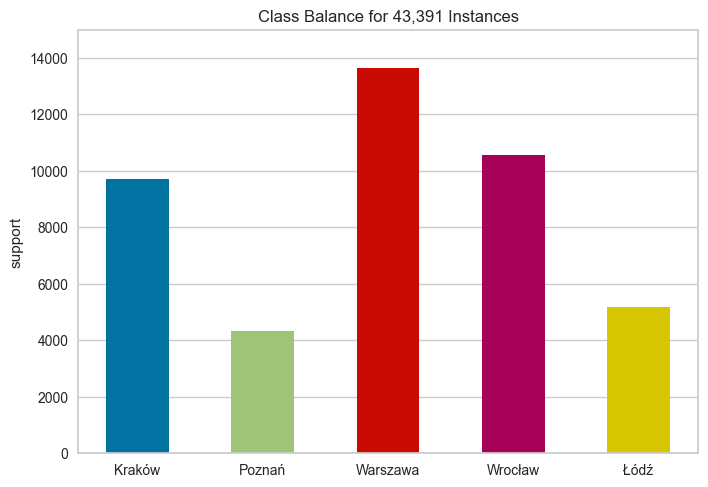

<Axes: title={'center': 'Class Balance for 43,391 Instances'}, ylabel='support'>

In [128]:
# Cities distribution

visualizer = ClassBalance()
visualizer.fit(df['city'])
visualizer.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'areaInSquareMeters'),
  Text(0, 1.5, 'price'),
  Text(0, 2.5, 'buildYear'),
  Text(0, 3.5, 'buildingFloorsNum'),
  Text(0, 4.5, 'latitude'),
  Text(0, 5.5, 'longitude')])

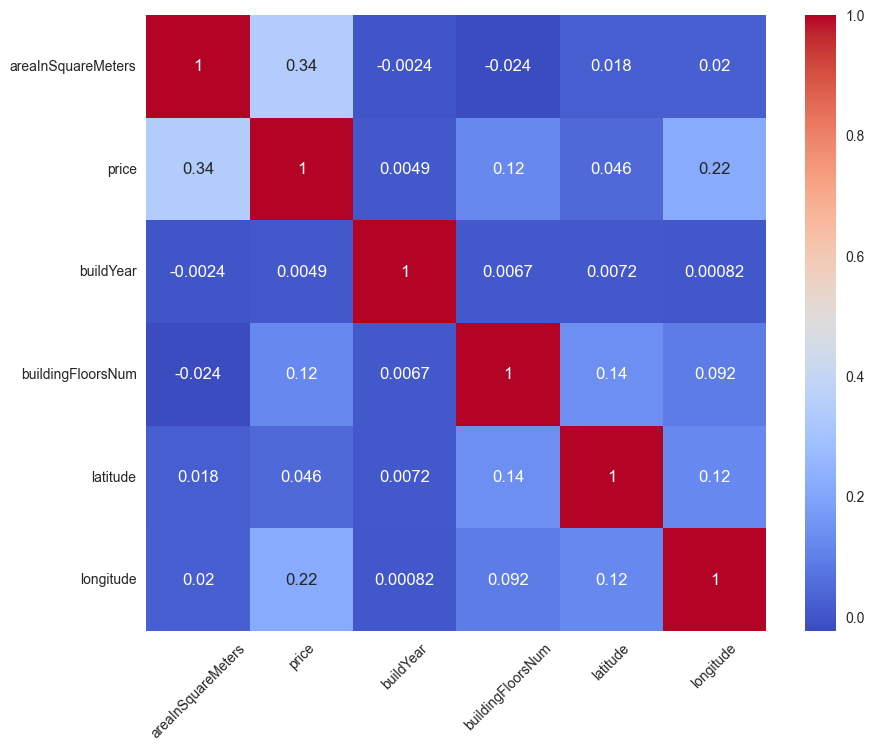

In [129]:
# Correlatiom Matrix Visualization - Heatmap

plt.figure(figsize=(10, 8))
correlations_matrix  = df.corr(numeric_only=True)
sns.heatmap(correlations_matrix, annot=True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

Dependent variable - price, shows more signifficant correlation for: area, buildingFloorsNum, longitude.

## Outliers

<Axes: >

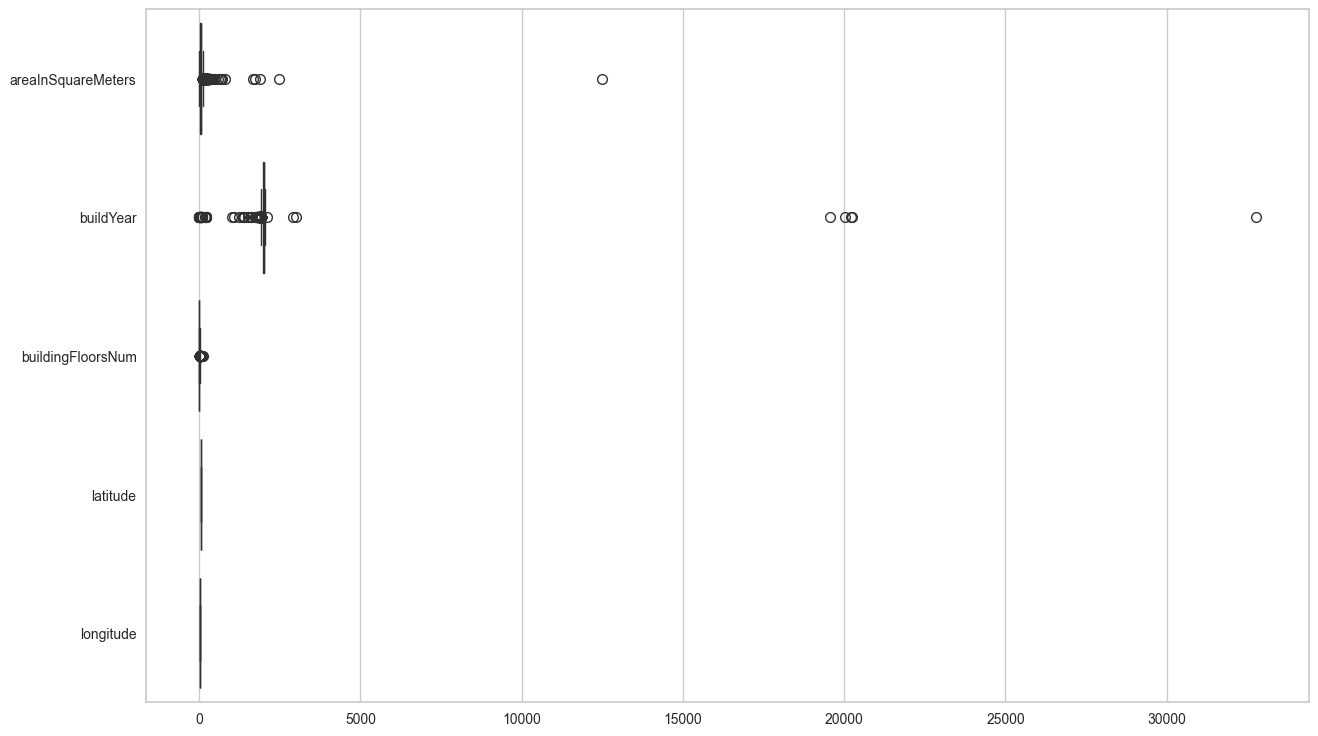

In [130]:
#visualizing outliers 
plt.figure(figsize=(15,9))
sns.boxplot(df.select_dtypes(include=np.number).drop(columns=["price"]), orient="h")

There are some signifficant outliers in dataset, mainly areaInSquareMeters and buildYear.


In areaInSquareMeeters some outliers shows positions that are wrongly classified or have errors in data. The biggest appartments in Poland are around 300 mkw (square meters). 

In buildYear we have a similar situation, flats should be casegorized as built between 1930-2050.

In [131]:
df.describe()

areaInSquareMeters         price     buildYear  buildingFloorsNum  \
count        43391.000000  4.339100e+04  36491.000000       41121.000000   
mean            57.785955  8.899724e+05   2000.006906           5.597335   
std             68.459732  7.137054e+05    260.204207           3.717802   
min             10.000000  1.297040e+03      1.000000           1.000000   
25%             40.400000  5.633165e+05   1979.000000           3.000000   
50%             51.710000  7.328690e+05   2017.000000           4.000000   
75%             66.000000  9.700000e+05   2024.000000           7.000000   
max          12500.000000  2.000000e+07  32767.000000         111.000000   

           latitude     longitude  
count  43391.000000  43391.000000  
mean      51.435970     19.208740  
std        0.868170      1.683704  
min       49.976250     16.814885  
25%       51.065740     17.037560  
50%       51.752690     19.912784  
75%       52.231170     20.952002  
max       52.490041     21.251730

In [61]:
# Removing outliers using Percentile-Based Capping (IQR Method) - only df set - # For visualization purpose
def remove_outliers_iqr(df, column="areaInSquareMeters"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    

    # Filter out outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df_out = remove_outliers_iqr(df) # For visualization purpose

In [62]:
# Removing outliers using Percentile-Based Capping (IQR Method) - only df set - # For visualization purpose
def remove_outliers_iqr(df, column="price"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df_out = remove_outliers_iqr(df_out) # For visualization purpose

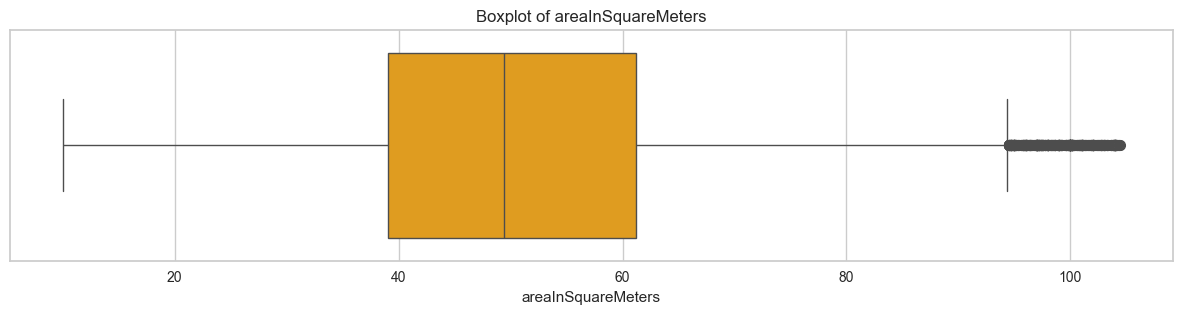

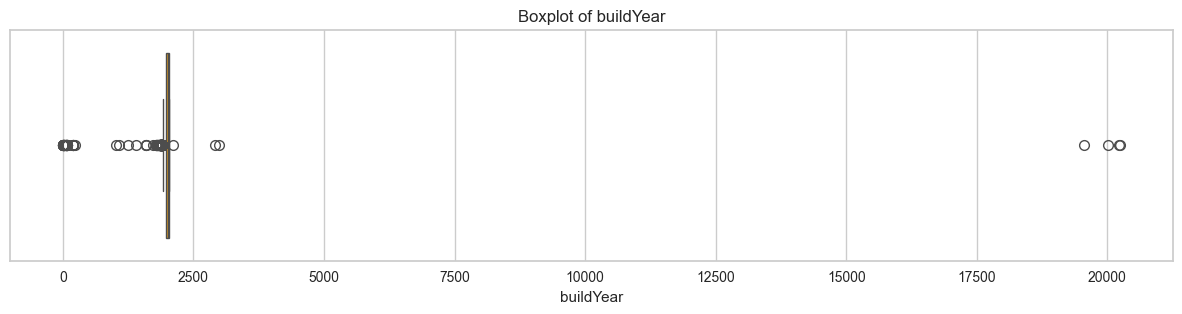

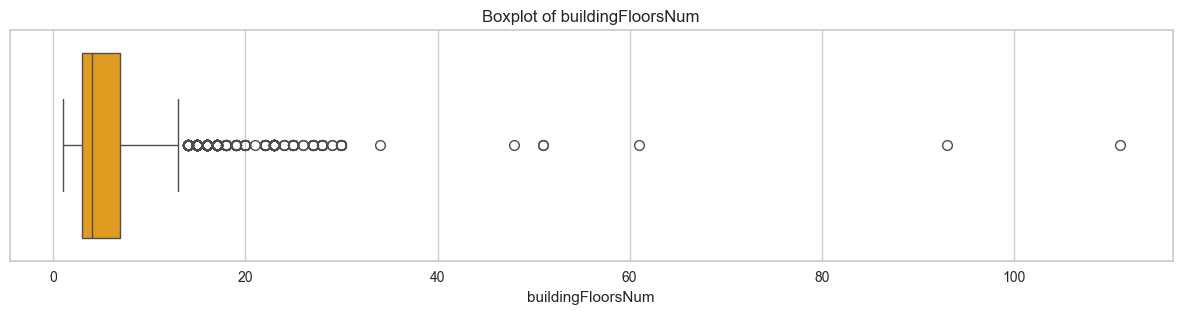

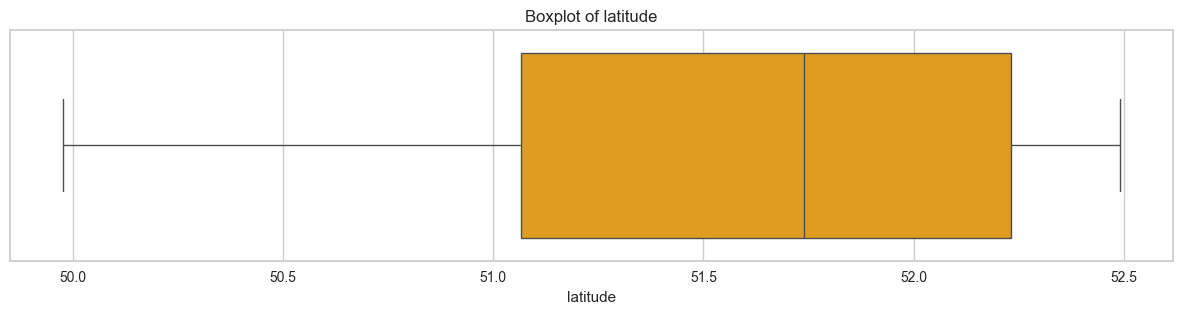

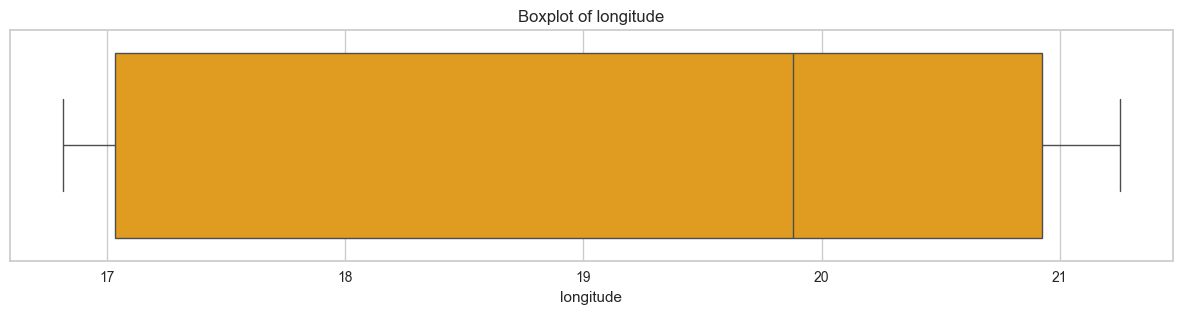

In [136]:
# Boxplot to detect outliers and see the spread
numeric = df_out.select_dtypes(include=np.number).drop(columns=["price"]).columns.tolist()
for i in numeric:
    plt.figure(figsize=(15, 3))
    sns.boxplot(x=df_out[i], color='orange')
    plt.title(f'Boxplot of {i}')
    plt.xlabel(i)
    plt.show()

## Data Distribution Analysis

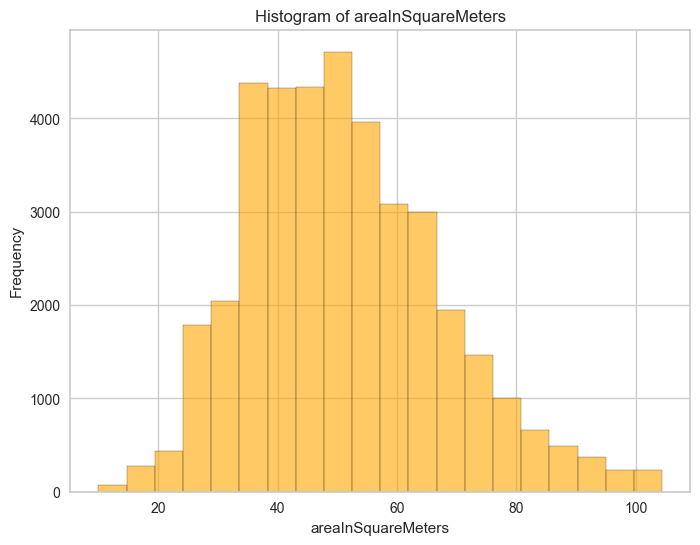

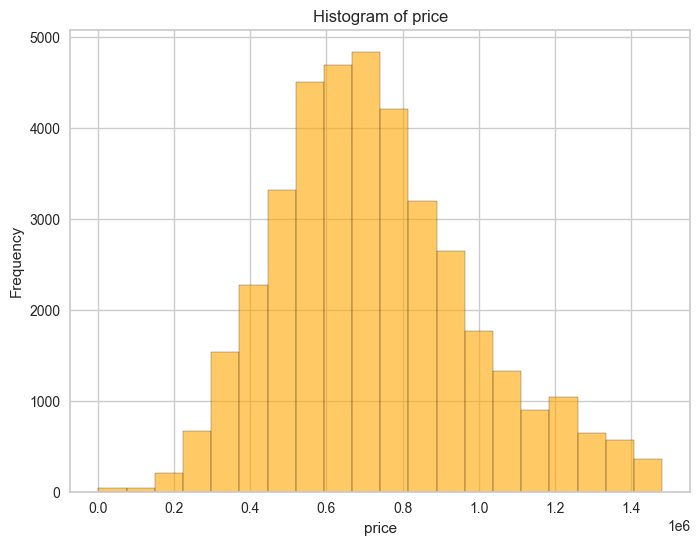

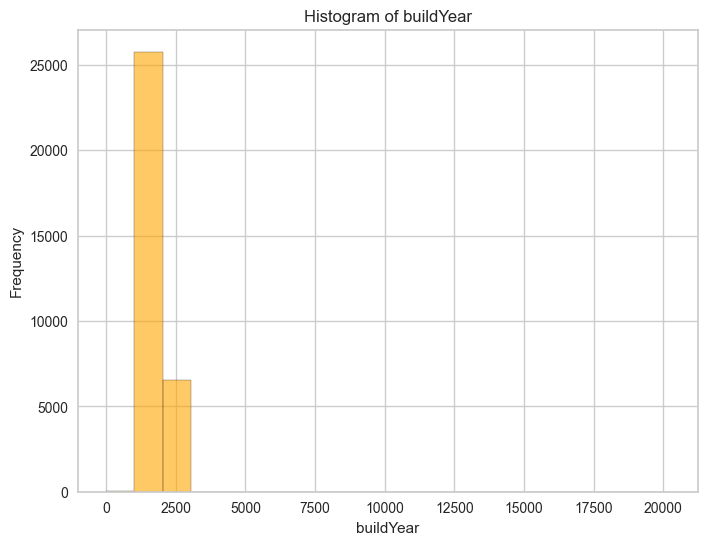

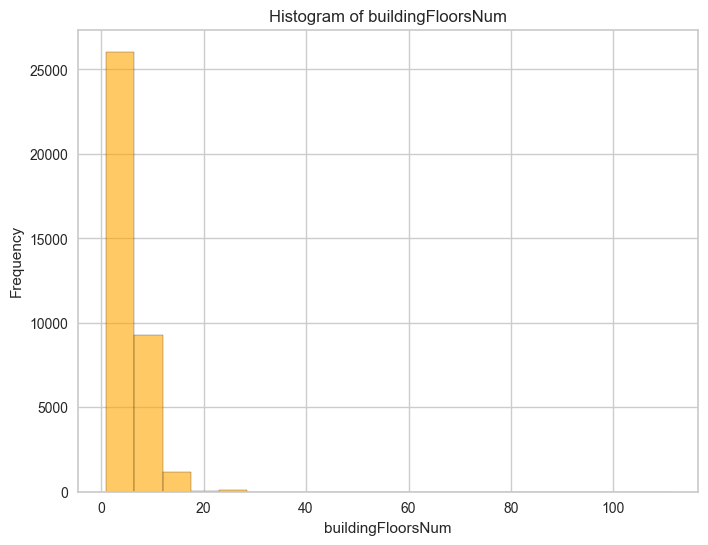

In [137]:
# Histogram to visualize the data distribution
numeric = df_out.select_dtypes(include=np.number).drop(columns=["latitude", "longitude"]).columns.tolist()
for i in numeric:
    plt.figure(figsize=(8, 6))
    plt.hist(df_out[i], bins=20, color='orange', edgecolor='black', alpha=0.6, label=i)
    plt.title(f'Histogram of {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()

We can notice that price, area, floors values are right skewed. 

The area histogram is nearly normal (bell-shaped). Log transformation is not necessary because normalizing an already normal feature is not useful.

The price histogram is highly skewed with a long tail on the right. It won't be logarithmically transformed, since we need to keep the model easily interpretable.

The building floors histogram is right-skewed with extreme values. Logarithimc transformation might be an option or binning.

Build Year - Log transformation is NOT suitable for categorical or time-based features.

## Mapping Categorical Variables, Filling Missing Values

In [80]:
# Mapping buildingOwnership
def ownership_mapping(df):
  df.loc[:, "buildingOwnership"] = np.where(df["buildingOwnership"] == "full_ownership", 1, 0)
  df["buildingOwnership"] = df["buildingOwnership"].astype(int)
  return df

# Mapping outdoor
def mapNa(df):
    df["outdoor"] = df["outdoor"].fillna("None")
    df["constructionStatus"] = df["constructionStatus"].fillna("None")
    return df
  
# Mapping market, advertiserType, advertType, rooms
def mapping(df):
  dict_map = {
      "PRIMARY": 1, "SECONDARY": 0, # market
      "business": 1, "private": 0, # advertiserType
      "DEVELOPER_UNIT": 1, "AGENCY": 1, "PRIVATE": 0, #advertType
      "ONE": 1, "TWO": 2, "THREE": 3, "FOUR": 4, "FIVE": 5, # rooms
      "SIX": 6, "SEVEN": 7, "EIGHT": 8, "NINE": 9, "TEN": 10, "MORE": 10
  }

  df["market"] = df["market"].map(dict_map)
  df["advertiserType"] = df["advertiserType"].map(dict_map)
  df["advertType"] = df["advertType"].map(dict_map)
  df["roomsNumber"] = df["roomsNumber"].map(dict_map)
  return df

# Scaling price to kPLN
def price_scaling(df):
  df["price"] = df["price"]/1000 #data scaling, now price in kPLN
  df["price"] = df["price"].round(2)
  return df

In [87]:
# Compute median and mode using only the training set
buildYear_median = strat_train_set["buildYear"].median()
buildingFloorsNum_median = strat_train_set["buildingFloorsNum"].median()
buildingType_mode = strat_train_set["buildingType"].mode()[0]

# Identify rare values (< 5%) based on training set
value_counts = strat_train_set["buildingType"].value_counts(normalize=True)
rare_values = value_counts[value_counts < 0.05].index

def fillNa(df):
    # Replace buildYear values outside[] with NaN
    df.loc[(df["buildYear"] > 2050) | (df["buildYear"] < 1930), "buildYear"] = np.nan
    
    df["buildYear"] = df["buildYear"].fillna(buildYear_median)  # Apply median from train
    df["buildingFloorsNum"] = df["buildingFloorsNum"].fillna(buildingFloorsNum_median)  # Apply median from train
    
    df["buildingType"] = df["buildingType"].replace(rare_values, buildingType_mode)  # Replace rare values using train data
    df["buildingType"] = df["buildingType"].fillna(buildingType_mode)  # Fill NaN with mode from train

    return df 

In [88]:
# Compute mode only from the training set
buildingType_mode = strat_train_set["buildingType"].mode()[0]

def fill_buildingType(df):
    df["buildingType"] = df["buildingType"].fillna(buildingType_mode)  # Use mode from train
    return df 

In [90]:
def mapping_priceScaling(df):
  ownership_mapping(df)
  mapNa(df)
  price_scaling(df)
  mapping(df)
  fillNa(df)
  fill_buildingType(df)
  return df

In [ ]:
df_out_map = mapping_priceScaling(df_out) # For visualization purpose
train_map = mapping_priceScaling(strat_train_set)
test_map = mapping_priceScaling(strat_test_set)

buildYear buildingFloorsNum have missing values as numerical features. Let's fill missing values an investigate multicorrlinearity

Most of models can't operate on dataframe with missing values

In [93]:
# Adding logarithmic transformation of buildingFloorsNum

def log(df):
    df["buildingFloorsNumLog"] = np.log1p(df["buildingFloorsNum"])
    return df


df_out_map = log(df_out_map) # For visualization purpose
train_map = log(train_map)
test_map = log(test_map)

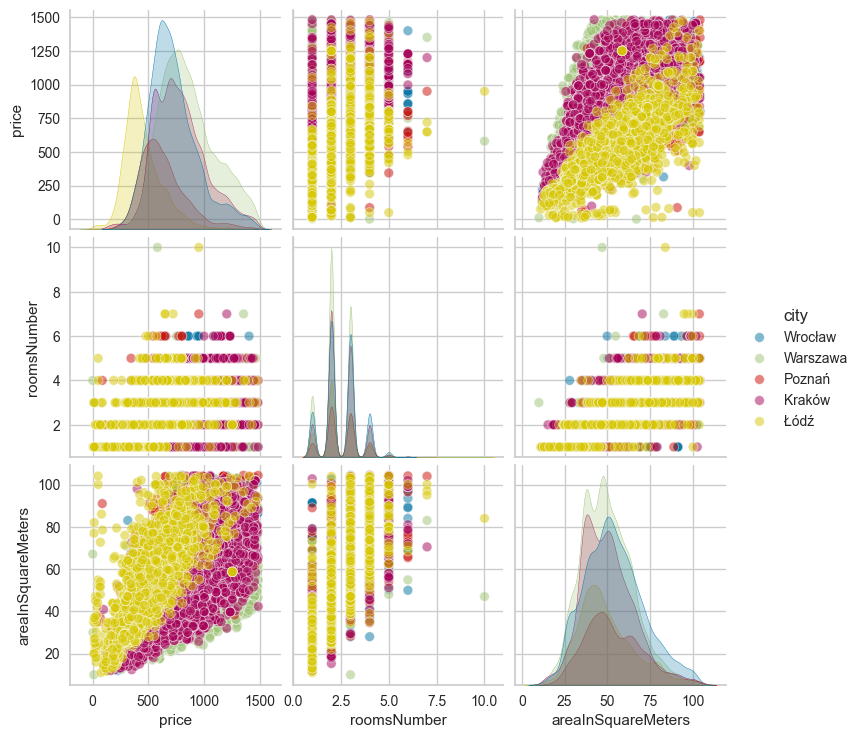

In [23]:
sns.pairplot(df_out_map[["city", "price", "roomsNumber", "areaInSquareMeters"]], hue="city", height=2.5, plot_kws={'alpha': 0.5})

Łódź city have signifficantly lover area/price rate 

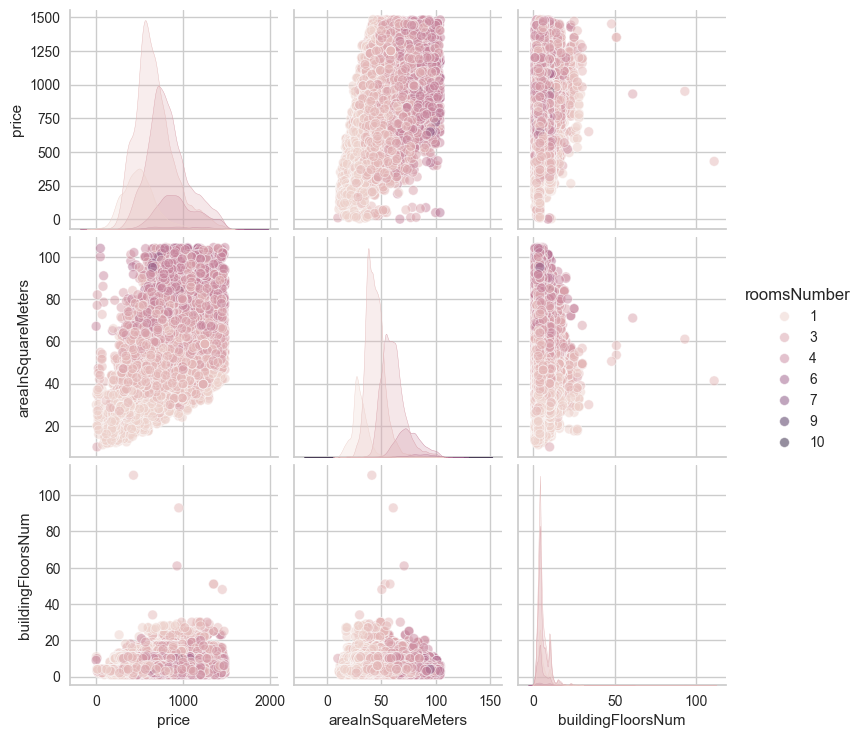

In [24]:
sns.pairplot(df_out_map[["price", "roomsNumber", "areaInSquareMeters", "buildingFloorsNum"]], hue="roomsNumber", height=2.5, plot_kws={'alpha': 0.5})

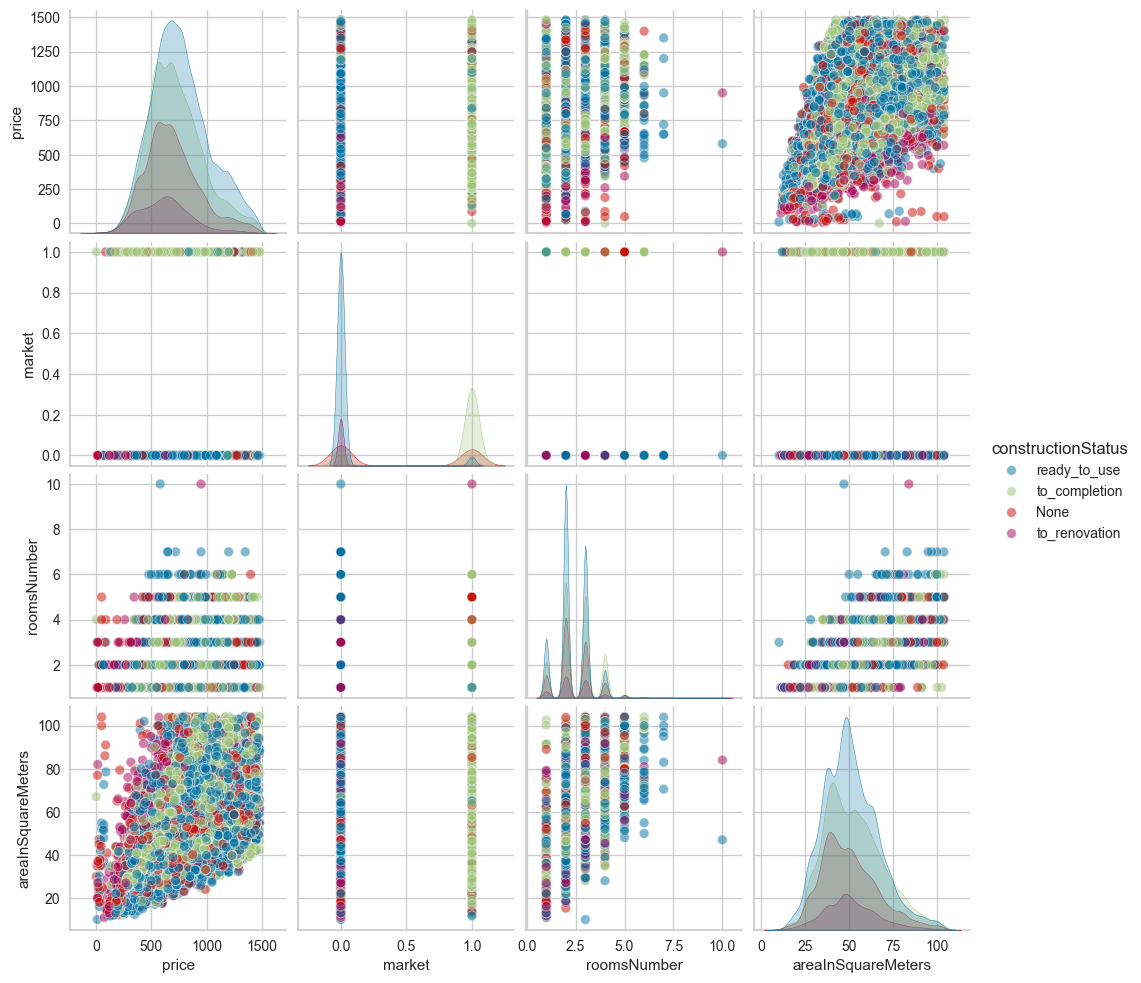

In [25]:
sns.pairplot(df_out_map[["price", "market", "roomsNumber", "areaInSquareMeters", "constructionStatus"]], hue="constructionStatus", height=2.5, plot_kws={'alpha': 0.5})

to renovation flats tend to be cheaper and price isn't growing rapidly with increasing area

(1) primary market mostly to_completion status

(0) secondary market mostly ready_to_use status, there are a signifficantly less to_renovation and to_completion

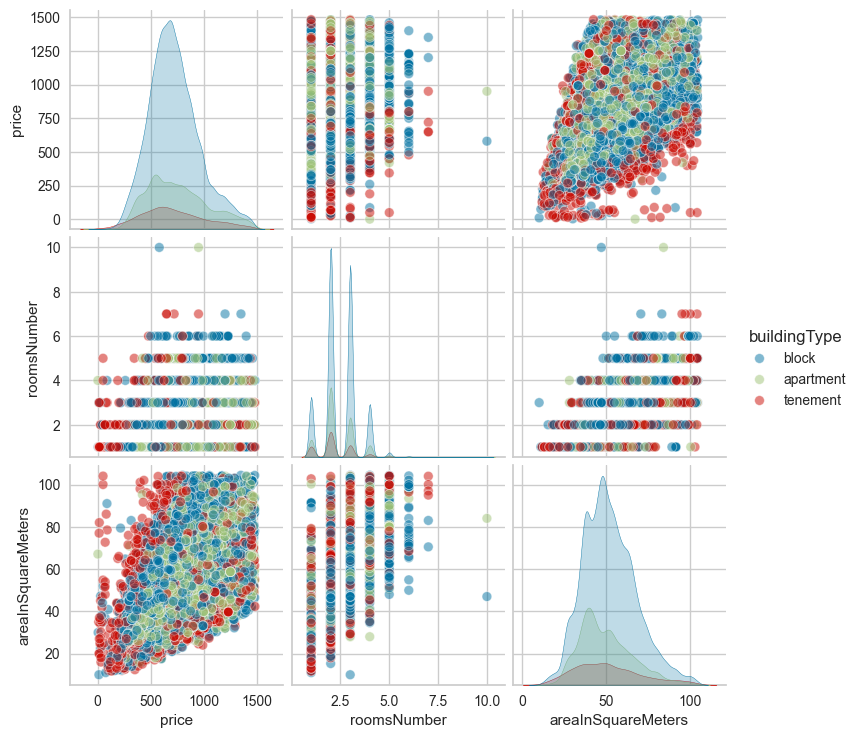

In [26]:
sns.pairplot(df_out_map[["price", "roomsNumber", "areaInSquareMeters", "buildingType"]], hue="buildingType", height=2.5, plot_kws={'alpha': 0.5})

We see different behavior area / privce / building type.  Price grows rapidly for apartments, less so for block, and even less for tenement.

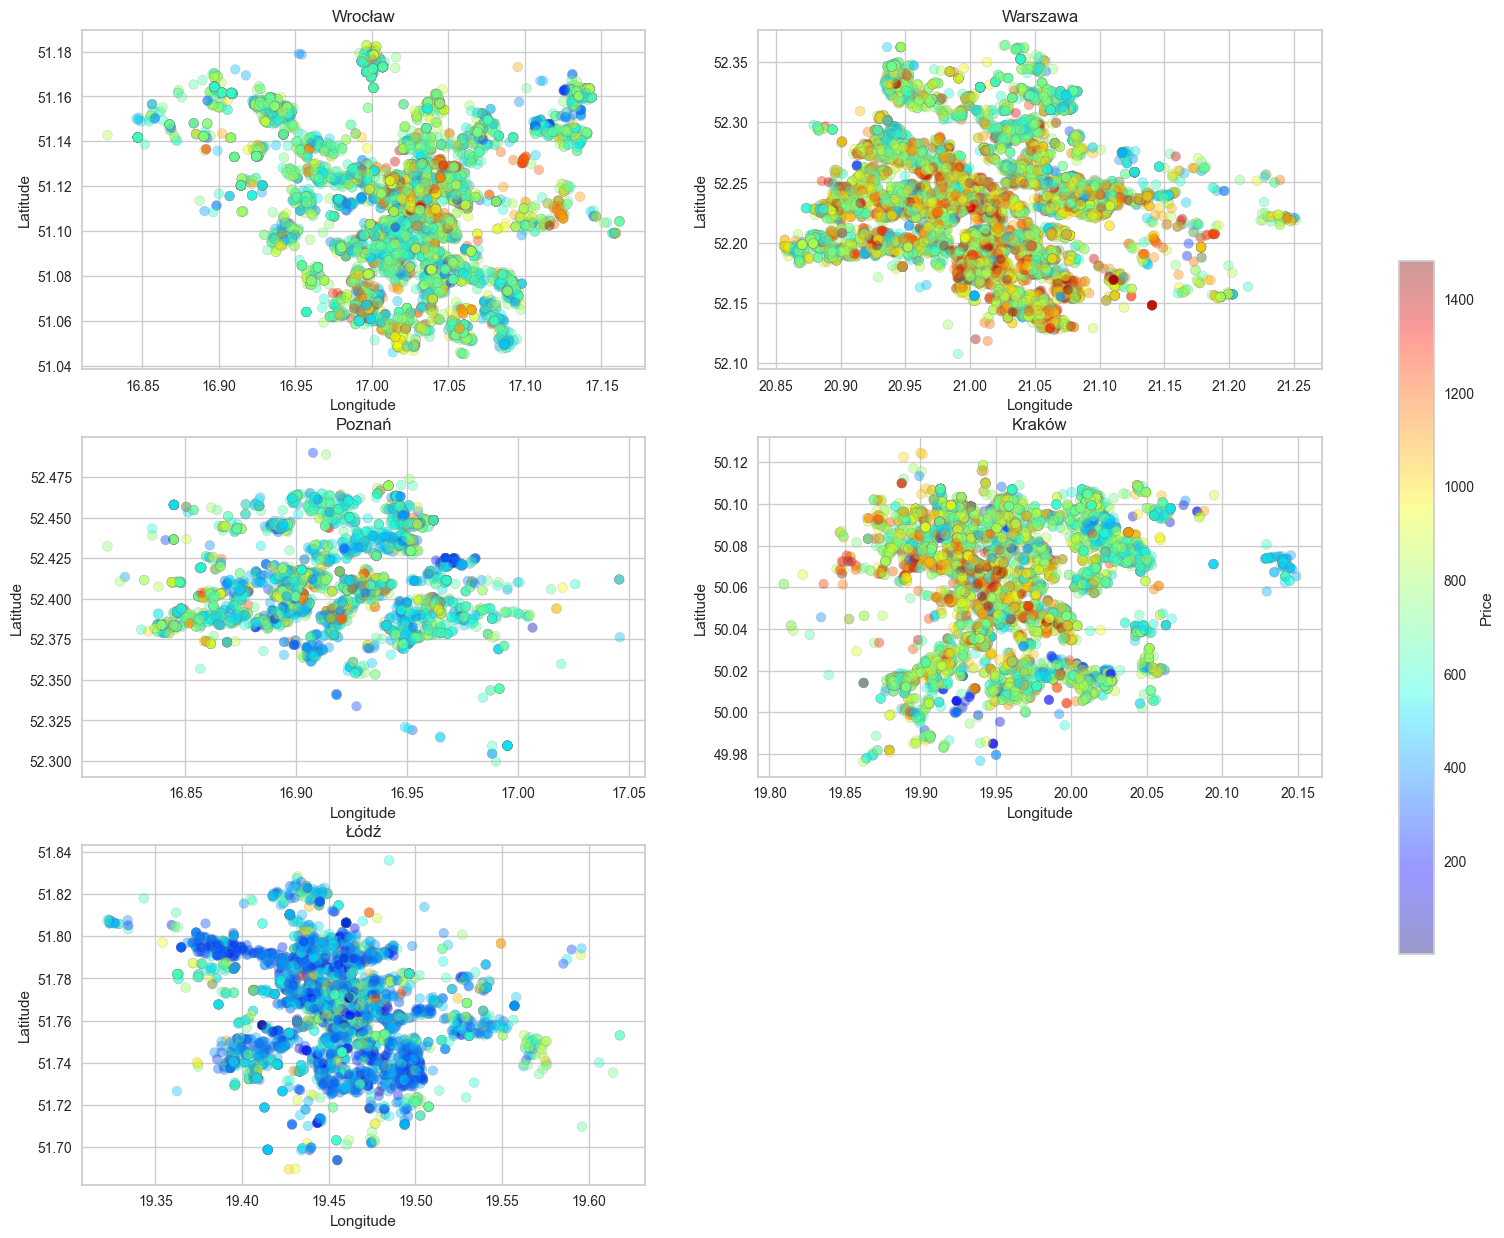

In [151]:
# Plotting geographical position of flats per city with color mapping of price

# Get list of unique cities
cities = list(df_out_map["city"].unique())

# Define subplot grid dynamically
rows, cols = (len(cities) // 2) + 1, 2

# Get global min & max price for consistent color scale
vmin = df_out_map["price"].min()
vmax = df_out_map["price"].max()

# Define axes array 
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through cities and plot
for i, city in enumerate(cities):
    city_data = df_out_map[df_out_map["city"] == city]
    
    scatter = axes[i].scatter(
        city_data["longitude"], city_data["latitude"], alpha=0.4, edgecolors='tab:gray', # Scatter values
        c=city_data["price"], cmap="jet", vmin=vmin, vmax=vmax # Colormap of price
    )
    
    axes[i].set_title(city)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

# Remove empty subplots (if cities < total subplot slots)
if len(axes) > i+1:
    fig.delaxes(axes[-1])


cbar = fig.colorbar(scatter, ax=axes, orientation="vertical", shrink=0.6)
cbar.set_label("Price") 

plt.show()

Each city has a unique distribution of housing densities and housing prices.

# Feature Engineering

In [ ]:
# ### PANDAS REPORT
# !pip install ydata-profiling
# from ydata_profiling import ProfileReport

In [ ]:
# prof = ProfileReport(df)
# prof.to_file(output_file='df.html')

## Aggregation / Binning 

In [94]:
# Compute bin edges from training set only
quantiles = pd.qcut(train_map["buildYear"], q=4, duplicates="drop", retbins=True)[1]  # Get bin edges

def buildYearBins(df, bins):
    df.loc[:, "buildYear_bins"] = pd.cut(
        df["buildYear"], 
        bins=bins, 
        labels=range(1, len(bins)),  # Adjust labels dynamically
        include_lowest=True
    ).astype("category").cat.codes
    return df

# Apply the same bins to all datasets
train_map = buildYearBins(train_map, quantiles)
test_map = buildYearBins(test_map, quantiles)  

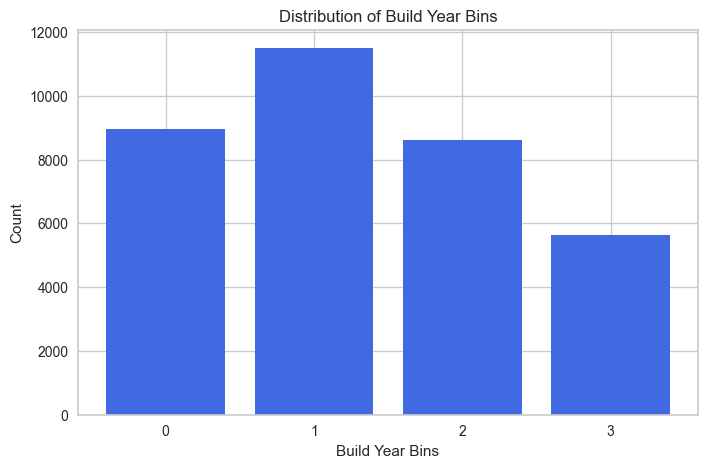

In [95]:
# Count occurrences of each bin
bin_counts = train_map['buildYear_bins'].value_counts().sort_index()

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(bin_counts.index, bin_counts.values, color='royalblue')

# Labels and title
plt.xlabel("Build Year Bins")
plt.ylabel("Count")
plt.title("Distribution of Build Year Bins")
plt.xticks(bin_counts.index)  # Ensure x-axis labels match bins

# Show plot
plt.show()


In [96]:
# Compute bin edges from training set only
quantiles = pd.qcut(train_map["buildingFloorsNum"], q=4, duplicates="drop", retbins=True)[1]  # Get bin edges

def buildingFloorsNumBins(df, bins):
    df.loc[:, "buildingFloorsNum_bins"] = pd.cut(
        df["buildingFloorsNum"], 
        bins=bins, 
        labels=range(1, len(bins)),  # Adjust labels dynamically
        include_lowest=True
    ).astype("category").cat.codes
    return df

# Apply the same bins to all datasets
train_map = buildingFloorsNumBins(train_map, quantiles)
test_map = buildingFloorsNumBins(test_map, quantiles)  

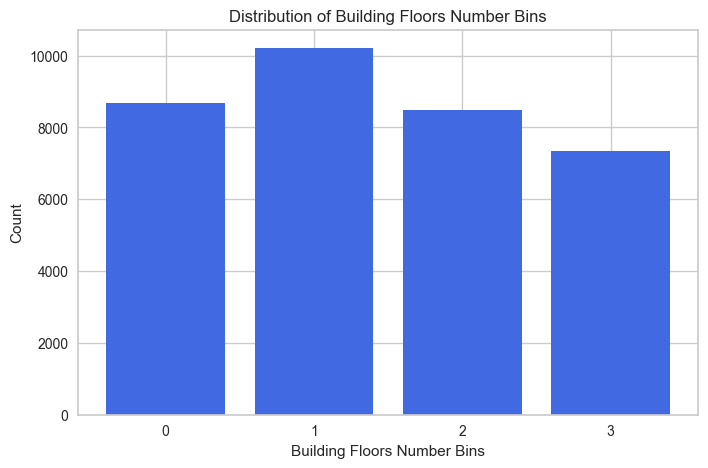

In [97]:
# Count occurrences of each bin
bin_counts = train_map['buildingFloorsNum_bins'].value_counts().sort_index()

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(bin_counts.index, bin_counts.values, color='royalblue')

# Labels and title
plt.xlabel("Building Floors Number Bins")
plt.ylabel("Count")
plt.title("Distribution of Building Floors Number Bins")
plt.xticks(bin_counts.index)  # Ensure x-axis labels match bins

# Show plot
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'areaInSquareMeters'),
  Text(0, 1.5, 'roomsNumber'),
  Text(0, 2.5, 'price'),
  Text(0, 3.5, 'market'),
  Text(0, 4.5, 'advertiserType'),
  Text(0, 5.5, 'advertType'),
  Text(0, 6.5, 'buildYear'),
  Text(0, 7.5, 'buildingFloorsNum'),
  Text(0, 8.5, 'buildingOwnership'),
  Text(0, 9.5, 'latitude'),
  Text(0, 10.5, 'longitude'),
  Text(0, 11.5, 'buildingFloorsNumLog'),
  Text(0, 12.5, 'buildYear_bins'),
  Text(0, 13.5, 'buildingFloorsNum_bins')])

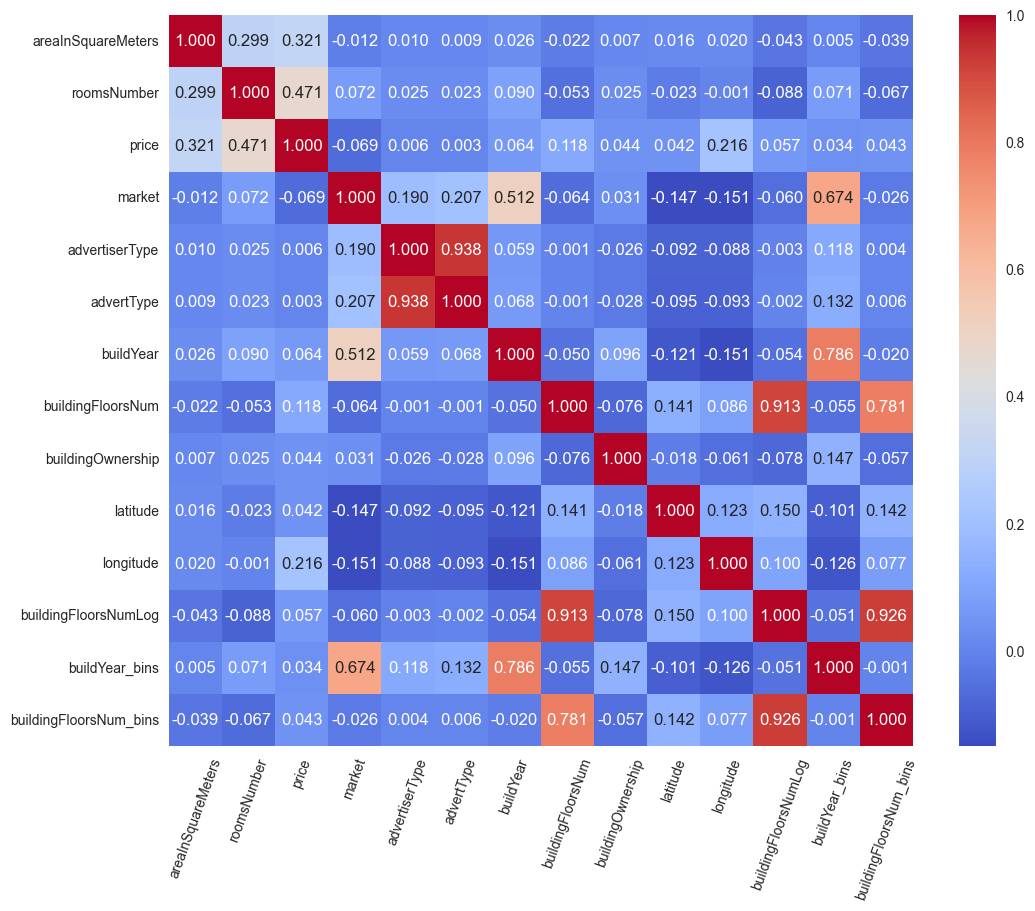

In [98]:
# Correlation Heatmap
plt.figure(figsize=(12, 9.5))
correlations_matrix  = train_map.corr(numeric_only=True)
sns.heatmap(correlations_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.xticks(rotation=70)
plt.yticks(rotation=0)

**Binning:**

buildYear binning improved correlation

buildingFloorsNum binning improved correlation

**Logarithmic Transformation:**

buildingFloorsNumLog shows worse correlation than base feature, this feature can be dropped.

## Data Enrichment

Integrating additional external or supplementary data into existing dataset to provide more context or improve model performance.

In [101]:
# Adding average cities population (data from official statistical government websites)
def add_population(df):
  df.insert(loc=len(df.columns), column = "population", value = df["city"])
  dict_map = {
      "Wrocław": 670000, "Poznań": 540000, "Łódź": 655000, "Warszawa": 1860000, "Kraków": 807600,
  }


  df["population"] = df["population"].map(dict_map)
  return df

# Adding average cities salary [PLN] (data from official statistical government websites)
def add_salary(df):
  df.insert(loc=len(df.columns), column = "avgSalary", value = df["city"])
  dict_map = {
      "Wrocław": 8900, "Poznań": 7400, "Łódź": 8100, "Warszawa": 9700, "Kraków": 10170,
  }

  df["avgSalary"] = df["avgSalary"].map(dict_map)
  return df


# Adding cities area [km2]
def add_area(df):
  df.insert(loc=len(df.columns), column="cityArea", value = df["city"], allow_duplicates=True)
  dict_map = {
      "Wrocław": 293, "Poznań": 262, "Łódź": 293, "Warszawa": 517, "Kraków": 327,
  }
  df['cityArea'] = df['cityArea'].map(dict_map)
  return df

def add_advanced_features(df):
  # Summing cities flats quantity
  wro_sum = (df['city']=="Wrocław").sum()
  poz_sum = (df['city']=="Poznań").sum()
  wwa_sum = (df['city']=="Warszawa").sum()
  kr_sum = (df['city']=="Kraków").sum()
  ldz_sum = (df['city']=="Łódź").sum()

  dict_map_sum = {"Wrocław":wro_sum, "Poznań":poz_sum, "Warszawa":wwa_sum, "Kraków":kr_sum, "Łódź":ldz_sum}

  #Population-to-Flat Ratio: population/total flats
  df.insert(loc=len(df.columns), column="Population_to_Flat_Ratio", value = df["city"], allow_duplicates=True)
  df['Population_to_Flat_Ratio'] = df['Population_to_Flat_Ratio'].map(dict_map_sum)
  df['Population_to_Flat_Ratio'] = round(df["population"] / df['Population_to_Flat_Ratio'])

  # Flat Availability Rate: total flats / population
  df.insert(loc=len(df.columns), column="Flat_Availability_Rate", value = df["city"], allow_duplicates=True)
  df['Flat_Availability_Rate'] = df['Flat_Availability_Rate'].map(dict_map_sum)
  df['Flat_Availability_Rate'] = df["Flat_Availability_Rate"] / df['population']

  #Flats per Income Unit: total flats/average salary
  df.insert(loc=len(df.columns), column="Flats_per_Income_Unit", value = df["city"], allow_duplicates=True)
  df['Flats_per_Income_Unit'] = df['Flats_per_Income_Unit'].map(dict_map_sum)
  df['Flats_per_Income_Unit'] = round(df["Flats_per_Income_Unit"] / df['avgSalary'], 2)

  # Housing Density: total flats/city area
  df['housingDensity'] = df['city'].map(dict_map_sum) / df["cityArea"]
  return df

In [102]:
def add_features(df):
  add_population(df)
  add_salary(df)
  add_area(df)
  add_advanced_features(df)
  return df

In [103]:
train_map = add_features(train_map)
test_map = add_features(test_map)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 [Text(0, 0.5, 'areaInSquareMeters'),
  Text(0, 1.5, 'roomsNumber'),
  Text(0, 2.5, 'price'),
  Text(0, 3.5, 'market'),
  Text(0, 4.5, 'advertiserType'),
  Text(0, 5.5, 'advertType'),
  Text(0, 6.5, 'buildYear'),
  Text(0, 7.5, 'buildingFloorsNum'),
  Text(0, 8.5, 'buildingOwnership'),
  Text(0, 9.5, 'latitude'),
  Text(0, 10.5, 'longitude'),
  Text(0, 11.5, 'buildingFloorsNumLog'),
  Text(0, 12.5, 'buildYear_bins'),
  Text(0, 13.5, 'buildingFloorsNum_bins'),
  Text(0, 14.5, 'population'),
  Text(0, 15.5, 'avgSalary'),
  Text(0, 16.5, 'cityArea'),
  Text(0, 17.5, 'Population_to_Flat_Ratio'),
  Text(0, 18.5, 'Flat_Availability_Rate'),
  Text(0, 19.5, 'Flats_per_Income_Unit'),
  Text(0, 20.5, 'housingDensity')])

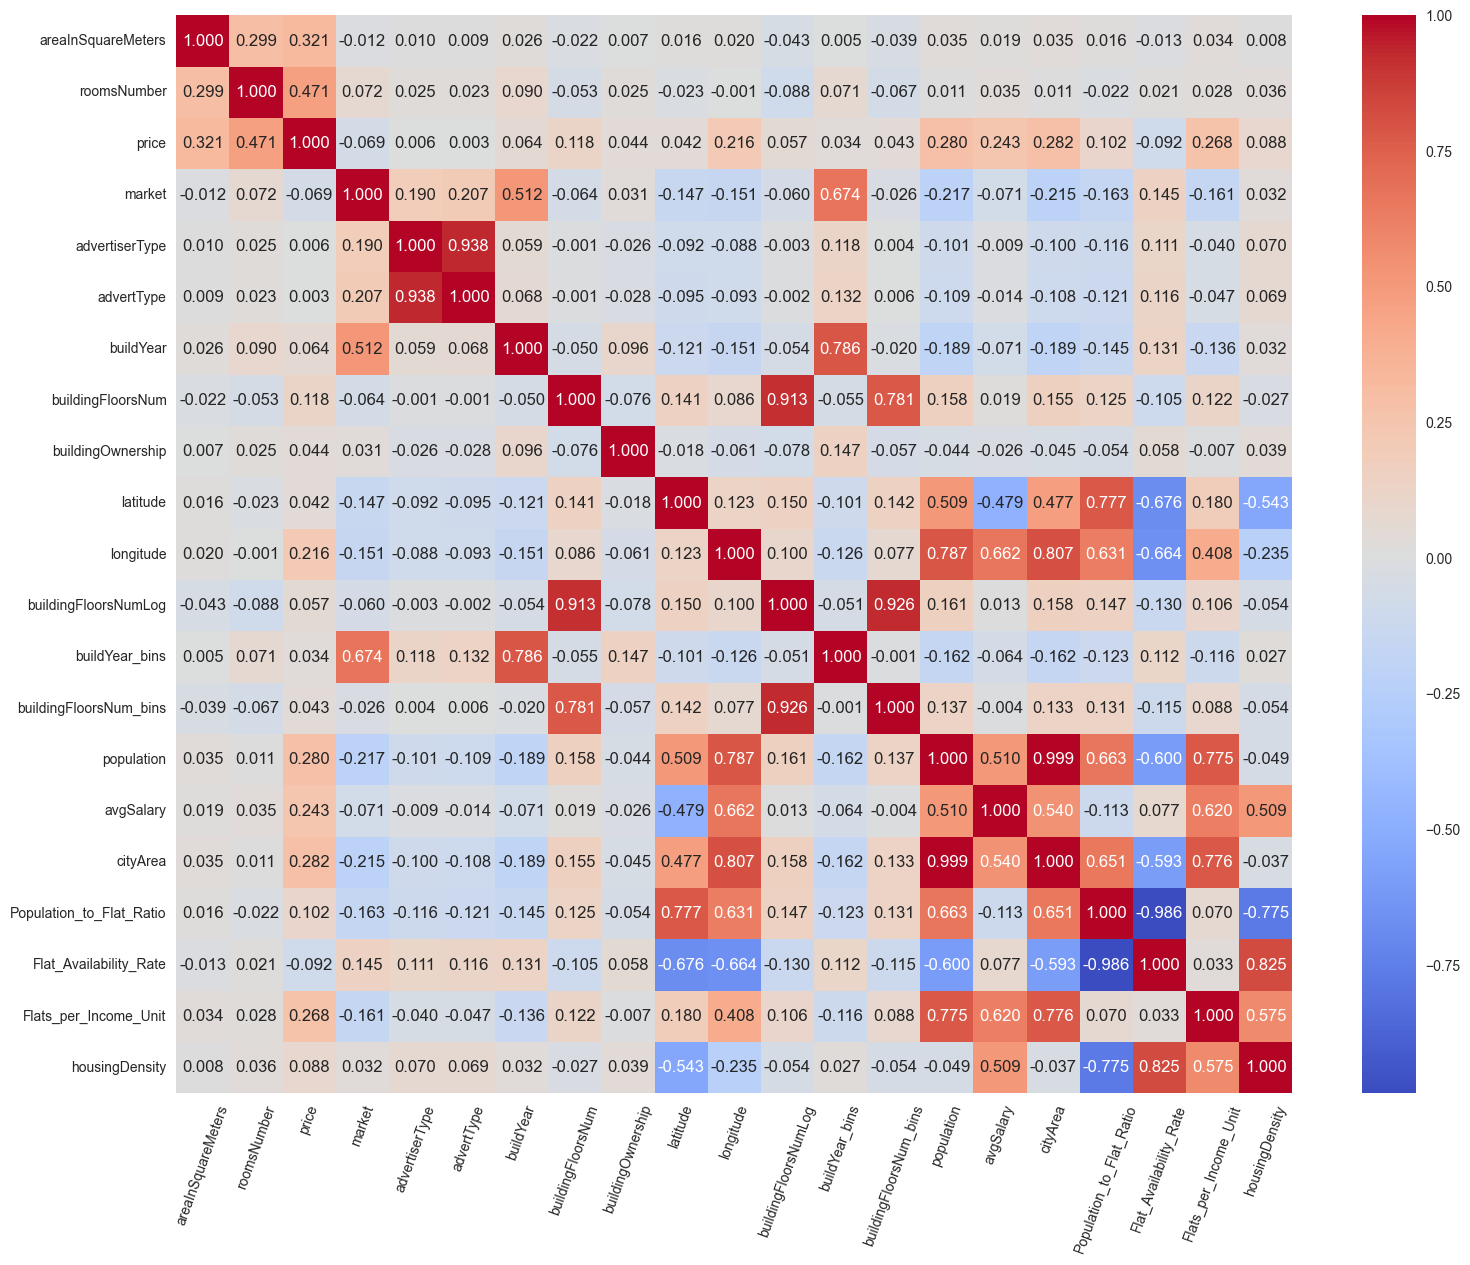

In [105]:
# Correlation Heatmap
plt.figure(figsize=(18, 14))
correlations_matrix  = train_map.corr(numeric_only=True)
sns.heatmap(correlations_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.xticks(rotation=70)
plt.yticks(rotation=0)

Additional supplementary data shows signifficant correlation with price.

## Multicollinearity 

In [109]:
# Checking multicollinearity for featurees before data enrichment
colums_to_drop = ["price", 'population', 'avgSalary', 'cityArea', 'Population_to_Flat_Ratio',
       'Flat_Availability_Rate', 'Flats_per_Income_Unit', 'housingDensity']
df_numerics_only = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns)

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF
vif_result = calculate_vif(train_map[df_numerics_only])
print("Variance Inflation Factors:")
print(vif_result)

Variance Inflation Factors:
                   feature          VIF
0       areaInSquareMeters     1.752616
1              roomsNumber     8.596523
2                   market     3.045958
3           advertiserType    78.805524
4               advertType    70.818902
5                buildYear  3102.647556
6        buildingFloorsNum    24.190630
7        buildingOwnership     4.168953
8                 latitude  2988.959674
9                longitude   136.947469
10    buildingFloorsNumLog   339.161294
11          buildYear_bins     5.874458
12  buildingFloorsNum_bins    23.856863


In [110]:
# Checking multicollinearity for featurees after data enrichment
colums_to_drop = ["price"]
df_numerics_only = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns)

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF
vif_result = calculate_vif(train_map[df_numerics_only])
print("Variance Inflation Factors:")
print(vif_result.round(3))

f:\repository\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors:
                     feature       VIF
0         areaInSquareMeters     1.103
1                roomsNumber     1.129
2                     market     1.960
3             advertiserType     8.298
4                 advertType     8.362
5                  buildYear     2.684
6          buildingFloorsNum     7.399
7          buildingOwnership     1.044
8                   latitude   602.859
9                  longitude  1038.413
10      buildingFloorsNumLog    20.733
11            buildYear_bins     3.668
12    buildingFloorsNum_bins     8.825
13                population       inf
14                 avgSalary       inf
15                  cityArea       inf
16  Population_to_Flat_Ratio       inf
17    Flat_Availability_Rate       inf
18     Flats_per_Income_Unit       inf
19            housingDensity       inf


Addressing high multicolinearity is necessary.
VIF>10 is treated as high multicolinearity. 

We can:

* Ignore it
* Throw out predictors
* Pool predictors
* Structural multicolinearity
* Penalized regression
* Specification errors

# Feature Selection

## Feature Importances and BorutaPy 

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error as MAE 
from sklearn.metrics import mean_absolute_percentage_error as MAPE

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import KBinsDiscretizer

In [34]:
# Test set evaluation and plotting confusion matrix
def evaluate_model_reg(preds, y_t, type):
    metrics = [MAE, MAPE, rmse, r2_score]
    scores = []
    """Evaluate the model's performance on train and test sets."""

    for metric in metrics:
        scores.append(metric(y_t, preds))

    print(f"\n=== {type} Metrics ===")
    print(f"MAE: {scores[0]:.4f}")
    print(f"MAPE: {scores[1]:.4f}")
    print(f"RMSE: {scores[2]:.4f}")
    print(f"R2 Score: {scores[3]:.4f}\n")



=== Train Metrics ===
MAE: 37.1685
MAPE: 0.0528
RMSE: 104.0553
R2 Score: 0.9785


=== Test Metrics ===
MAE: 147.2811
MAPE: 0.1662
RMSE: 276.5032
R2 Score: 0.8553


📊 Sorted Feature Importances:
num__areaInSquareMeters: 0.6283
num__longitude: 0.1345
num__buildingFloorsNum: 0.0694
num__latitude: 0.0661
num__buildYear: 0.0329
cat__buildingType_block: 0.0141
cat__buildingType_apartment: 0.0068
num__Flats_per_Income_Unit: 0.0052
num__population: 0.0051
num__housingDensity: 0.0047
cat__constructionStatus_ready_to_use: 0.0047
num__avgSalary: 0.0047
cat__buildingType_tenement: 0.0038
cat__outdoor_None: 0.0033
cat__outdoor_balcony: 0.0030
cat__outdoor_terrace: 0.0028
cat__constructionStatus_to_completion: 0.0023
cat__constructionStatus_None: 0.0023
cat__constructionStatus_to_renovation: 0.0016
num__Flat_Availability_Rate: 0.0016
num__cityArea: 0.0012
num__Population_to_Flat_Ratio: 0.0011
cat__outdoor_garden: 0.0005


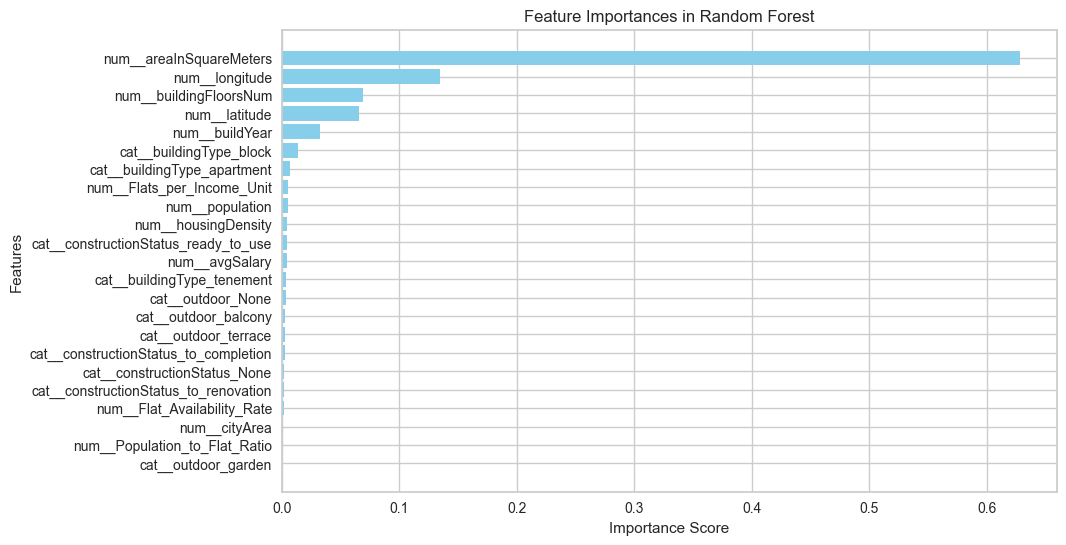

In [112]:
# Feature Importances for featurees after data enrichment, already selected with the most promising features
# Based on VIF, Heatmap and Feature importances, columns to drop were chosen without signifficant influence on performance 
# ("district", "subdivision", "city") dropped, they introduce variancy and engage a lot of additional computational resources

colums_to_drop = ["price", "buildingFloorsNum_bins", "buildYear_bins", "buildingFloorsNumLog", "advertType", "advertiserType", "buildingOwnership", "market", "roomsNumber", 
                  "district", "subdivision", "city",
                  ]

num_features = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop)
y_train = train_map["price"]

X_test = test_map.drop(columns=colums_to_drop)
y_test = test_map["price"]

# Remove target variable 'price' from features list
if "price" in num_features:
    num_features.remove("price")
if "price" in cat_features:
    cat_features.remove("price")
    
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])

# Fit the preprocessor separately and transform the train & test data
X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data (DO NOT FIT AGAIN)

# Train model directly (No Pipeline)
model = RandomForestRegressor(random_state=42)
model.fit(X_train_transformed, y_train)

# Simple Random Forest for feature importances
preds_train= model.predict(X_train_transformed)
preds_test = model.predict(X_test_transformed)
  
# Evaluate model
evaluate_model_reg(preds_train, y_train, "Train")
evaluate_model_reg(preds_test, y_test, "Test")

# Get feature importances
feature_names = preprocessor.get_feature_names_out()
importance = model.feature_importances_

feature_importance_dict = dict(zip(feature_names, importance))
# feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})

# Print feature importances
sorted_importances = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("\n📊 Sorted Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

# Visualizing feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_importances],
    [x[1] for x in sorted_importances],
    color='skyblue'
)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importances in Random Forest")
plt.gca().invert_yaxis()  # Flip the y-axis to show the most important features at the top
plt.show()

No high gain in implementing PCA since there are't a lot of features correlated between each other. Usually 2 features correlated. Benefits of PCA are more noticeable when you have multiple correlated features.  

### BorutaPy

In [ ]:
# BorutaPy with regression - on already slightly filtered set by gained insights from feature importances
colums_to_drop = ["price", "buildingFloorsNum_bins", "buildYear_bins", "buildingFloorsNumLog", "advertType", "advertiserType", "buildingOwnership", "market", 
                  "district", "subdivision", "city"]

# With drop first in OHE, regression for BorutaPy

num_features = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop)
X_test = test_map.drop(columns=colums_to_drop)

y_train = train_map["price"]
y_test = test_map["price"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])
# OHE drop="first"
# If all categories are kept, one column can be perfectly predicted from the others, leading to redundancy (multicollinearity).
# Dropping the first category reduces this issue while still preserving information.
# Decision trees are not affected by multicollinearity as much as linear models are - try both

# Fit the preprocessor separately and transform the train & test data
X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data (DO NOT FIT AGAIN)

model = RandomForestRegressor(random_state=42)

boruta_selector = BorutaPy(model, n_estimators="auto", verbose=-2, random_state=42)
boruta_selector.fit(X_train_transformed, y_train)

feature_names = preprocessor.get_feature_names_out()
# Create DataFrame with feature names, ranking, and selection status
selected_features_df = pd.DataFrame({
    "Feature": feature_names,
    "Ranking": boruta_selector.ranking_,
    "Selected": boruta_selector.support_
})

# Sort by ranking (1 = most important features)
sorted_features_df = selected_features_df.sort_values(by="Ranking")

print("Selected Features by BorutaPy:")
print(sorted_features_df)

# call transform() on X to filter it down to selected features
# X_filtered = boruta_selector.transform(X_train_transformed)

# Transform dataset to keep only selected features
X_train_selected = boruta_selector.transform(X_train_transformed)
X_test_selected = boruta_selector.transform(X_test_transformed)

# Train final model on selected features
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_train_selected, y_train)

# Simple Random Forest for feature importances
preds_train= final_model.predict(X_train_selected)
preds_test = final_model.predict(X_test_selected)
  
# Evaluate model
evaluate_model_reg(preds_train, y_train, "Train")
evaluate_model_reg(preds_test, y_test, "Test")

Selected Features by BorutaPy:
                                  Feature  Ranking  Selected
0                 num__areaInSquareMeters        1      True
2                          num__buildYear        1      True
3                  num__buildingFloorsNum        1      True
4                           num__latitude        1      True
5                          num__longitude        1      True
1                        num__roomsNumber        2     False
13                cat__buildingType_block        3     False
7                          num__avgSalary        4     False
6                         num__population        5     False
11             num__Flats_per_Income_Unit        6     False
12                    num__housingDensity        7     False
15   cat__constructionStatus_ready_to_use        8     False
14             cat__buildingType_tenement        9     False
20                   cat__outdoor_terrace       10     False
18                   cat__outdoor_balcony       11    

In [ ]:
# BorutaPy with classification - on already slightly filtered set by gained insights from feature importances
colums_to_drop = ["price", "buildingFloorsNum_bins", "buildYear_bins", "buildingFloorsNumLog", "advertType", "advertiserType", "buildingOwnership", "market",  
                  "district", "subdivision", "city"]

# Drop target variable and unwanted columns
num_features = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop)
X_test = test_map.drop(columns=colums_to_drop)

y_train = train_map["price"]
y_test = test_map["price"]

# Preprocessing: Standard Scaler for numbers, OneHotEncoder for categorical variables
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), cat_features)
])

# Fit only on training data and transform both train & test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert regression target into classification bins
kbins = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
y_train_binned = kbins.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Use BorutaPy with a classifier
model = RandomForestClassifier(random_state=42)
boruta_selector = BorutaPy(model, n_estimators="auto", verbose=-2, random_state=42)
boruta_selector.fit(X_train_transformed, y_train_binned)

# Extract selected feature names
feature_names = preprocessor.get_feature_names_out()
# Create DataFrame with feature names, ranking, and selection status
selected_features_df = pd.DataFrame({
    "Feature": feature_names,
    "Ranking": boruta_selector.ranking_,
    "Selected": boruta_selector.support_
})

# Sort by ranking (1 = most important features)
sorted_features_df = selected_features_df.sort_values(by="Ranking")

print("Selected Features by BorutaPy:")
print(sorted_features_df)

# Transform dataset to keep only selected features
X_train_selected = boruta_selector.transform(X_train_transformed)
X_test_selected = boruta_selector.transform(X_test_transformed)

# Train final model on selected features
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_train_selected, y_train)

# Simple Random Forest for feature importances
preds_train= final_model.predict(X_train_selected)
preds_test = final_model.predict(X_test_selected)
  
# Evaluate model
evaluate_model_reg(preds_train, y_train, "Train")
evaluate_model_reg(preds_test, y_test, "Test")

Selected Features by BorutaPy:
                                  Feature  Ranking  Selected
0                 num__areaInSquareMeters        1      True
2                          num__buildYear        1      True
5                          num__longitude        1      True
4                           num__latitude        1      True
1                        num__roomsNumber        2     False
3                  num__buildingFloorsNum        3     False
13                cat__buildingType_block        4     False
15   cat__constructionStatus_ready_to_use        5     False
7                          num__avgSalary        6     False
18                   cat__outdoor_balcony        7     False
11             num__Flats_per_Income_Unit        8     False
16  cat__constructionStatus_to_completion        9     False
6                         num__population       10     False
12                    num__housingDensity       11     False
9           num__Population_to_Flat_Ratio       12    

BorutaPy in a very short time and relatively short and simple code showed importances of features and gave the means to transform quicly dataset for further model analysis. It's a very good tool features selection.

In [155]:
# Possible sets to work with for further ML analysis, based on feature importances and BorutaPy

# Features to drop, to preserve the most important features 
colums_to_drop_basic = ['roomsNumber', 'price', 'market',
'advertiserType', 'advertType', 'buildingFloorsNum',
'buildingOwnership', 'buildingType', 'constructionStatus', 
'outdoor', 'subdivision', 'district', 'city',
'buildingFloorsNumLog', 'buildYear_bins', 'buildingFloorsNum_bins',
'population', 'avgSalary', 'cityArea', 'Population_to_Flat_Ratio',
'Flat_Availability_Rate', 'Flats_per_Income_Unit', 'housingDensity']

# Features to drop, to preserve extended features
colums_to_drop_extended = ['price', 'market',
'advertiserType', 'advertType', 
'buildingOwnership',  
'outdoor', 'subdivision', 'district', 'city',
'buildingFloorsNumLog', 'buildYear_bins', 'buildingFloorsNum_bins',
'cityArea', 'Population_to_Flat_Ratio',
'Flat_Availability_Rate']


# Multi-ML

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
# Models for initial multi-model check
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Polynomial Regression3": Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('lr', LinearRegression())]),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "LightGBM": LGBMRegressor(),
    "XGBoost": XGBRegressor()
}


In [165]:
# Evaluation of model predictions
def evaluate_model(models, X_train, y_train, X_test, y_test):
    metrics = [MAE, MAPE, rmse, r2_score]
    scores_train = []
    scores_test = []
    """Evaluate the model's performance on train and test sets."""
    plt.figure(figsize=(12,8))

    for i, (name, model) in enumerate(models.items()):
      # Train model
      model.fit(X_train, y_train)

      # Predictions
      preds_train = model.predict(X_train)
      preds_test = model.predict(X_test)

      model_scores_train = {"Model": name}
      model_scores_test = {"Model": name}
      for metric in metrics:
         model_scores_train[metric.__name__] = metric(y_train, preds_train)
         model_scores_test[metric.__name__] = metric(y_test, preds_test)
      scores_train.append(model_scores_train)
      scores_test.append(model_scores_test)

      # Scatter plot for actual vs predicted values
      plt.subplot(4, 3, i + 1)  # Adjusting for more models
      plt.scatter(y_test, preds_test, alpha=0.5, edgecolors='k')
      plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
      plt.xlabel('Actual Values')
      plt.ylabel('Predicted Values')
      plt.title(f'{name}: Actual vs Predicted')

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)
    
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format='%.4f'))
    
    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format='%.4f'))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 34712, number of used features: 4
[LightGBM] [Info] Start training from score 888.799697


f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


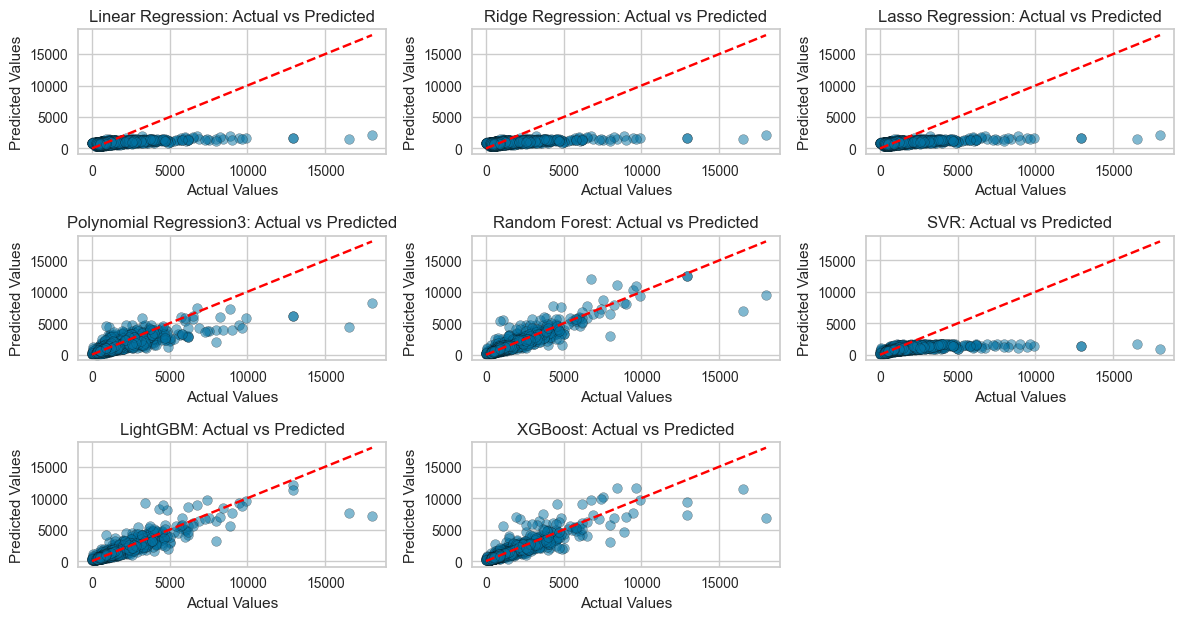


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error       rmse  r2_score
     Linear Regression           321.114726                        0.472730 652.983674  0.155060
      Ridge Regression           321.115043                        0.472730 652.983674  0.155060
      Lasso Regression           321.066689                        0.472557 652.986920  0.155052
Polynomial Regression3           192.620200                        0.247741 399.470973  0.683778
         Random Forest            37.876236                        0.055547 110.834576  0.975657
                   SVR           222.929864                        0.238870 589.182469  0.312107
              LightGBM           108.363094                        0.161222 230.860277  0.894386
               XGBoost            85.584632                        0.131951 144.974114  0.958351

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error       

In [49]:
# Testing models performance for basic features - base for further comparisons
num_features = list(train_map.drop(columns=colums_to_drop_basic).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop_basic).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop_basic)
X_test = test_map.drop(columns=colums_to_drop_basic)

y_train = train_map["price"]
y_test = test_map["price"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])

X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data 
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

The scatter of predictions vs. true prices shows points mostly aligned along the diagonal, indicating the model captures much of the price variation. However, at lower price ranges the spread is wider – the model struggles relatively more with inexpensive apartments. This heteroscedastic pattern means the model’s Mean Absolute Percentage Error (MAPE) is influenced by larger errors on lower-priced properties. Overall, achieved a high R² and a moderate RMSE. 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 33354, number of used features: 4
[LightGBM] [Info] Start training from score 834.157604


f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


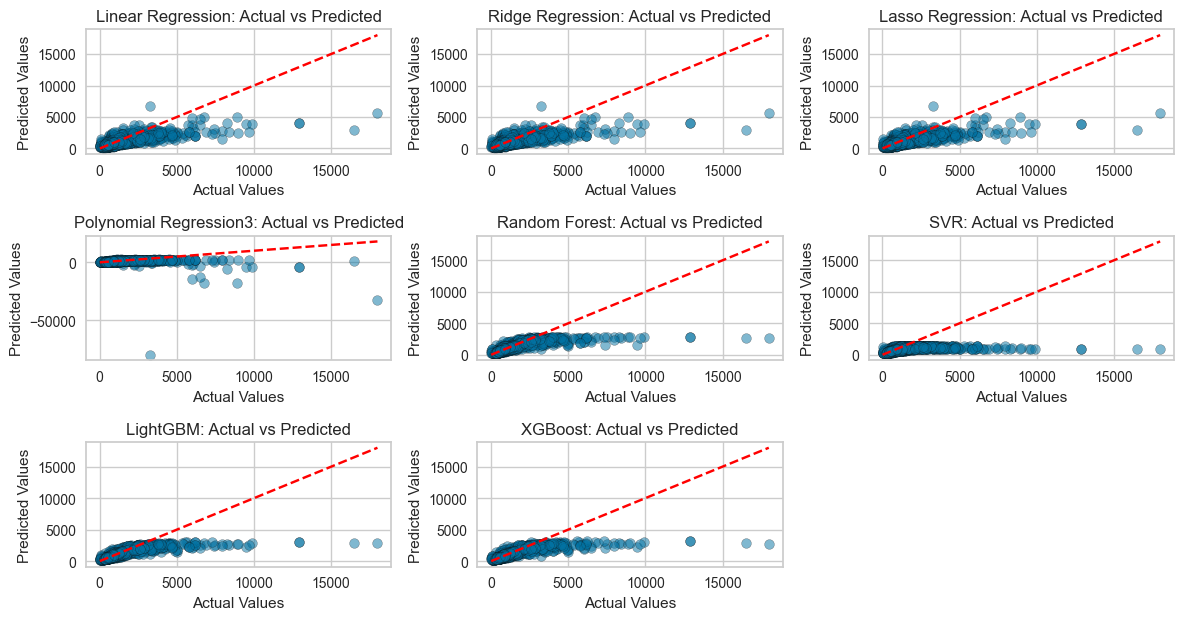


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error       rmse  r2_score
     Linear Regression           189.725939                        0.245869 271.821433  0.571074
      Ridge Regression           189.724994                        0.245868 271.821433  0.571074
      Lasso Regression           189.509012                        0.245475 271.829343  0.571049
Polynomial Regression3           148.807888                        0.170916 226.489758  0.702208
         Random Forest            30.060241                        0.034638  53.298702  0.983509
                   SVR           164.428952                        0.174149 277.016303  0.554522
              LightGBM            88.509274                        0.104534 138.144770  0.889214
               XGBoost            73.984504                        0.088591 114.268709  0.924200

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error       

In [ ]:
# Testing models performance for basic features - removing 1 percentile of outliers on training set
train_out_map_add_quan = train_map.copy()

def remove_outl(df):
    q_lower = 0.01
    q_higher = 0.99
    df = df[(df["areaInSquareMeters"] <= df["areaInSquareMeters"].quantile(q_higher)) & (df["areaInSquareMeters"] >= df["areaInSquareMeters"].quantile(q_lower))]
    df = df[(df["price"] <= df["price"].quantile(q_higher)) & (df["price"] >= df["price"].quantile(q_lower))]
    return df

train_out_map_add_quan = remove_outl(train_out_map_add_quan)


num_features = list(train_out_map_add_quan.drop(columns=colums_to_drop_basic).select_dtypes(include=np.number).columns)
cat_features = list(train_out_map_add_quan.drop(columns=colums_to_drop_basic).select_dtypes(include=['object']).columns)

X_train = train_out_map_add_quan.drop(columns=colums_to_drop_basic)
X_test = test_map.drop(columns=colums_to_drop_basic)

y_train = train_out_map_add_quan["price"]
y_test = test_map["price"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])

X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

Removing outliers on train set improves simple linear models performance, but impare tree-based models. Based on that analysis it's visible, that removing outliers isn't good for pursuing the best models performance. It requires additional step in data preparation and isn't providing sufficient leverage.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 34712, number of used features: 4
[LightGBM] [Info] Start training from score 15.341011


f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


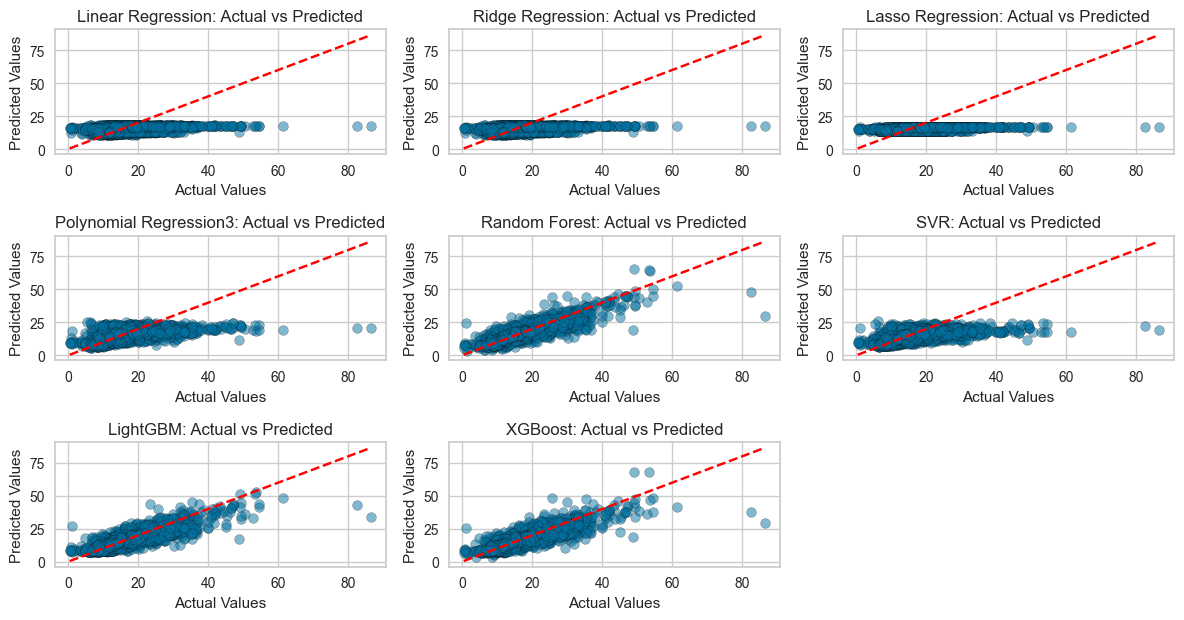


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error     rmse  r2_score
     Linear Regression             3.594481                        0.313495 5.071144  0.148668
      Ridge Regression             3.594477                        0.313495 5.071144  0.148668
      Lasso Regression             3.676728                        0.321601 5.190952  0.107966
Polynomial Regression3             2.862073                        0.233244 4.270558  0.396251
         Random Forest             0.528739                        0.051710 0.910494  0.972556
                   SVR             2.642900                        0.214777 4.223303  0.409538
              LightGBM             1.640617                        0.161076 2.478694  0.796608
               XGBoost             1.386940                        0.131269 2.076948  0.857197

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error     rmse  r2_score
     

In [116]:
# Testing models performance for basic features - changing labels to price per square meter
colums_to_drop_basic_priceM2 = colums_to_drop_basic.copy()
colums_to_drop_basic_priceM2.append("priceM2")

def price_to_M2(df):
    df["priceM2"] = df["price"] / df["areaInSquareMeters"]
    return df

# train_out_map_add_area = train_map.copy()
# test_map_add_area = test_map.copy()

train_map = price_to_M2(train_map)
test_map = price_to_M2(test_map)

num_features = list(train_map.drop(columns=colums_to_drop_basic_priceM2).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop_basic_priceM2).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop_basic_priceM2)
X_test = test_map.drop(columns=colums_to_drop_basic_priceM2)

y_train = train_map["priceM2"]
y_test = test_map["priceM2"]


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])

X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data 
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 34712, number of used features: 17
[LightGBM] [Info] Start training from score 15.341011


f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


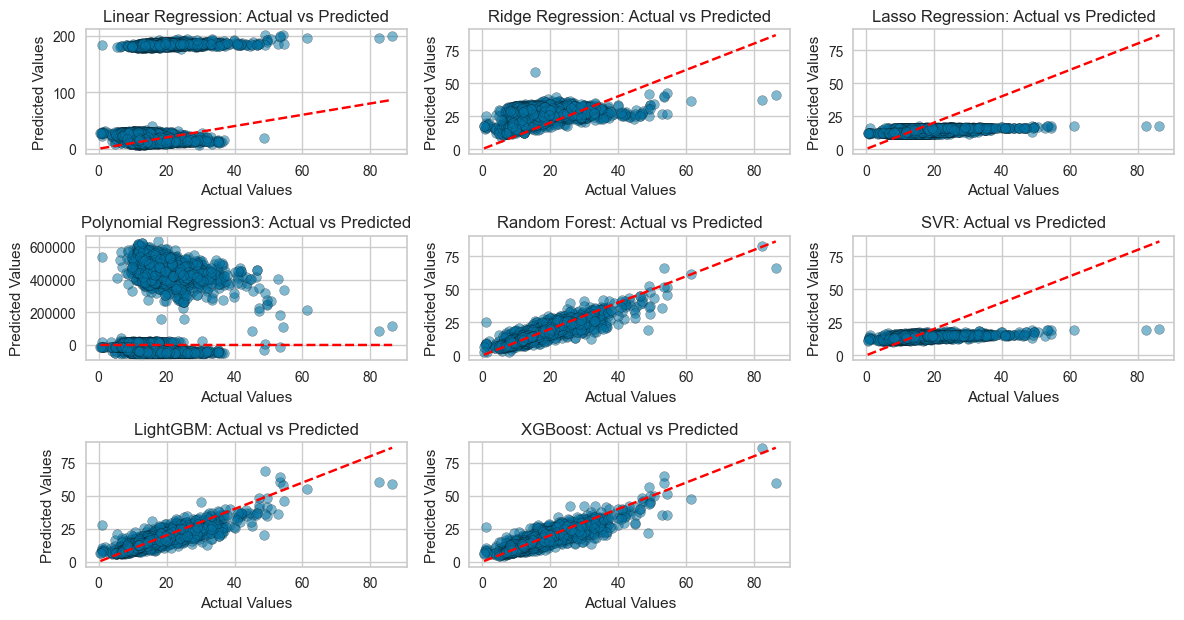


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
     Linear Regression               2.7475                          0.2412 4.0153    0.4663
      Ridge Regression               2.7501                          0.2414 4.0172    0.4658
      Lasso Regression               3.2996                          0.2844 4.7070    0.2665
Polynomial Regression3               1.9637                          0.1694 2.9814    0.7057
         Random Forest               0.4980                          0.0497 0.8533    0.9759
                   SVR               2.2091                          0.1850 3.6320    0.5633
              LightGBM               1.5382                          0.1520 2.3038    0.8243
               XGBoost               1.2835                          0.1258 1.9203    0.8779

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error        rmse         r2_score
     Linear R

In [172]:
# Testing models performance for extended features - with labels price per square meter
colums_to_drop_extended_priceM2 = colums_to_drop_extended.copy()
colums_to_drop_extended_priceM2.append("priceM2")

def price_to_M2(df):
    df["priceM2"] = df["price"] / df["areaInSquareMeters"]
    return df


train_map = price_to_M2(train_map)
test_map = price_to_M2(test_map)

num_features = list(train_map.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop_extended_priceM2)
X_test = test_map.drop(columns=colums_to_drop_extended_priceM2)

y_train = train_map["priceM2"]
y_test = test_map["priceM2"]


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])

X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data 
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

**Best outcome: extended features - Random Forest, XGB, LGBM. Labels: price per square meter.**

MAPE results for analysis price per square meter are better that MAPE for flat price. By predicting on a per-square-meter basis, the model handles small and large apartments more consistently.

Linear Model (e.g. OLS Linear Regression) – This had the highest bias and lowest variance. It underfits the data: the training and test R² were both relatively low (the model fails to capture complex location and quality effects), but importantly the train–test gap was small. This indicates the linear model is too rigid (high bias) but generalizes consistently (no overfitting).

Tree-Based Models (e.g. Decision Tree, Random Forest) – low bias but very high variance (overfitting the training data). 

***Random Forest***

High but manageable generalization gap in R².

Low MAE in both train and test, making it one of the best performers.

Conclusion: Random Forest provides a strong balance between bias and variance, making it a top contender.


***XGBoost***

Slightly better generalization than Random Forest.

Low MAE, very close to Random Forest.

Conclusion: XGBoost generalizes better than Random Forest. Slightly lower performance.


***LightGBM***

Train R² = 0.79, Test R² = 0.77 – excellent generalization.

Conclusion: LightGBM performs nearly as well as XGBoost but might be easier to tune.

# Hyperparameters Tuning

In [202]:



# Read the dataset
df = read()
# Drop unnecessary data
df = drop_data(df)
# Remove [''] characters from scrapped data
df = cleaning_data(df)
# Extract location from str
df = split_location(df)

# Stratify and split 
strat_train_set, strat_test_set = split(stratify(df)) # df For visualization purpose
df = df.drop(columns=["stratified", "price_cat", "areaInSquareMeters_cat", "buildYear_cat"])

# Mapping and price scaling
df_out_map = mapping_priceScaling(df_out) # For visualization purpose
train_map = mapping_priceScaling(strat_train_set)
test_map = mapping_priceScaling(strat_test_set)

# Adding logarithmic transformation of buildingFloorsNum
df_out_map = log(df_out_map) # For visualization purpose
train_map = log(train_map)
test_map = log(test_map)

# Binning buildYear
train_map = buildYearBins(train_map, quantiles)
test_map = buildYearBins(test_map, quantiles) 

# Binning buildingFloorsNum
train_map = buildingFloorsNumBins(train_map, quantiles)
test_map = buildingFloorsNumBins(test_map, quantiles)  

# Data enrichment
train_map = add_features(train_map)
test_map = add_features(test_map)


def price_to_M2(df):
    df["priceM2"] = df["price"] / df["areaInSquareMeters"]
    return df
train_map = price_to_M2(train_map)
test_map = price_to_M2(test_map)


train, validation = split(stratify(train_map)) 
train_map = train_map.drop(columns=["stratified", "price_cat", "areaInSquareMeters_cat", "buildYear_cat"])



# Features to drop, to preserve the most important features 
colums_to_drop_basic = ['roomsNumber', 'price', 'market',
'advertiserType', 'advertType', 'buildingFloorsNum',
'buildingOwnership', 'buildingType', 'constructionStatus', 
'outdoor', 'subdivision', 'district', 'city',
'buildingFloorsNumLog', 'buildYear_bins', 'buildingFloorsNum_bins',
'population', 'avgSalary', 'cityArea', 'Population_to_Flat_Ratio',
'Flat_Availability_Rate', 'Flats_per_Income_Unit', 'housingDensity']

# Features to drop, to preserve extended features
colums_to_drop_extended = ['price', 'market',
'advertiserType', 'advertType', 
'buildingOwnership',  
'outdoor', 'subdivision', 'district', 'city',
'buildingFloorsNumLog', 'buildYear_bins', 'buildingFloorsNum_bins',
'cityArea', 'Population_to_Flat_Ratio',
'Flat_Availability_Rate']


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import time 

In [195]:
# Model training, counting predictions and  training metrics
def model_tuning(model, param_grid, model_name, nIter):

  folds = KFold(n_splits = 10, shuffle = True, random_state=42)
  metrics = [MAE, MAPE, rmse, r2_score]

  # RandomizedSearchCV
  GS = RandomizedSearchCV(
      estimator=model,
      param_distributions=param_grid,
      n_iter=nIter,
      scoring= 'neg_mean_squared_error',
      cv=folds,
      return_train_score=True,
      verbose=0,
      n_jobs=-1,  # Use all CPUs
      refit=True,
      random_state=42
  )
  
  
  # Training model
  GS.fit(X_train_transformed, y_train)
  best_model = GS.best_estimator_
  best_params = GS.best_params_
  preds_train= GS.predict(X_train_transformed)
  preds_test = GS.predict(X_test_transformed)

  # Training metrics
  scores_train = []
  scores_test = []
  
  model_scores_train = {}
  model_scores_test = {}
  for metric in metrics:
      model_scores_train[metric.__name__] = metric(y_train, preds_train)
      scores_train.append(model_scores_train)

  for metric in metrics:
      model_scores_test[metric.__name__] = metric(y_test, preds_test)
      scores_test.append(model_scores_test)

  print(scores_test)
  # Convert results to DataFrame and display
  results_df_train = pd.DataFrame(scores_train)
  results_df_test = pd.DataFrame(scores_test)
  
  print("\n=== Train Metrics ===")
  print(results_df_train.to_string(index=False, float_format='%.4f'))
    
  print("\n=== Test Metrics ===")
  print(results_df_test.to_string(index=False, float_format='%.4f'))

  # Saving the best model
  folder_path = "../models/"
  filename = f"{model_name}.sav"
  pickle.dump(best_model, open(f"{folder_path}{filename}", "wb"))
  
  print(f"\nBest Parameters: {best_params}")
  
  # Scatter plot for actual vs predicted values
  plt.figure(figsize=(10,6))
  plt.scatter(y_test, preds_test, alpha=0.5, edgecolors='k')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title("Actual vs Predicted")
  plt.show()
  
  
  return best_model, preds_test

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 34712, number of used features: 17
[LightGBM] [Info] Start training from score 15.341011


f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
f:\repository\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[{'mean_absolute_error': 1.459171170199027, 'mean_absolute_percentage_error': 0.10387974063791124, 'rmse': np.float64(2.3121020774345014), 'r2_score': 0.8309844926907988}, {'mean_absolute_error': 1.459171170199027, 'mean_absolute_percentage_error': 0.10387974063791124, 'rmse': np.float64(2.3121020774345014), 'r2_score': 0.8309844926907988}, {'mean_absolute_error': 1.459171170199027, 'mean_absolute_percentage_error': 0.10387974063791124, 'rmse': np.float64(2.3121020774345014), 'r2_score': 0.8309844926907988}, {'mean_absolute_error': 1.459171170199027, 'mean_absolute_percentage_error': 0.10387974063791124, 'rmse': np.float64(2.3121020774345014), 'r2_score': 0.8309844926907988}]

=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.1952                          0.1208 1.7870    0.8943
              1.1952                          0.1208 1.7870    0.8943
              1.1952                          0.1208 1.7870    0.8943
            

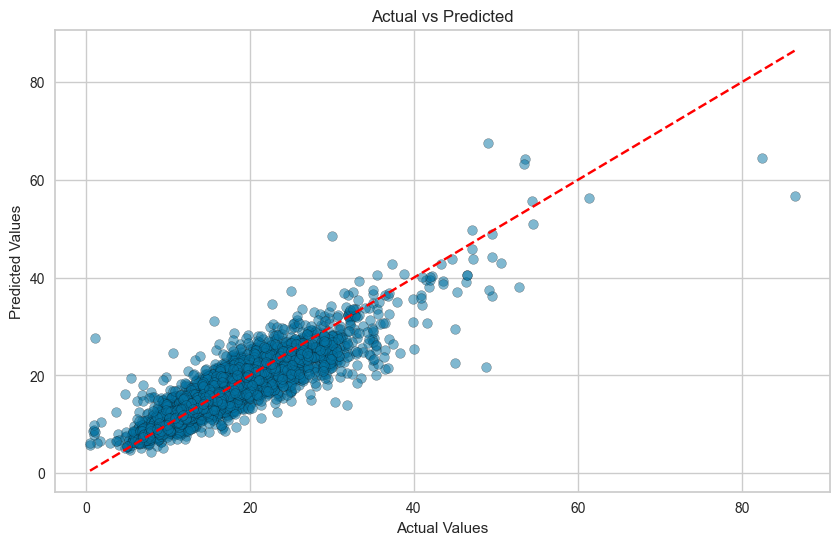

Search took 5.31 seconds.


In [196]:
colums_to_drop_extended_priceM2 = colums_to_drop_extended.copy()
colums_to_drop_extended_priceM2.append("priceM2")

num_features = list(train_map.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=np.number).columns)
cat_features = list(train_map.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=['object']).columns)

X_train = train_map.drop(columns=colums_to_drop_extended_priceM2)
X_test = test_map.drop(columns=colums_to_drop_extended_priceM2)

y_train = train_map["priceM2"]
y_test = test_map["priceM2"]


preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
])

X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
X_test_transformed = preprocessor.transform(X_test)        # Transform test data 


# Model instantiation
model = LGBMRegressor(random_state=42)

model_name = "reg_LGBM"

# TIme counter
start = time.time()

# Parameter Grid
param_grid = {
    'n_estimators': [500],  # Number of boosting rounds (trees)
    # 'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    # 'max_depth': [-1, 20],  # Tree depth (-1 means no limit)
    # 'num_leaves': [30, 40],  # Maximum number of leaves per tree
    # 'min_child_samples': [30, 50],  # Minimum number of samples in a leaf
    # 'subsample': [0.6, 0.7, 0.8],  # Fraction of data used per iteration
    # 'colsample_bytree': [0.95, 1.0],  # Fraction of features used per iteration
    # 'reg_alpha': [0.05, 0.15, 0.1],  # L1 regularization
    # 'reg_lambda': [0.05, 0.1, 0.15]  # L2 regularization
}

nIter = 1 # Number of parameter settings to be sampled by RandomizedSearchCV

LGBM_reg, preds_LGBM_reg  = model_tuning(model, param_grid, model_name, nIter)
print(
    "Search took %.2f seconds."
    % ((time.time() - start))
)

It's much more typically used for things like neural networks and gradient boosting (XGBoost, LightGBM etc.). These models will keep on making the solution more complex the more iterations you do, can approximate arbitrarily complex functions and - given enough features and time - overfit as much as you like. no early stopping na RF

#################################################EARLY STOPPING

In [236]:
# Model training, counting predictions and  training metrics
def model_tuning(model, param_grid, model_name, nIter):

  folds = KFold(n_splits = 10, shuffle = True, random_state=42)
  metrics = [MAE, MAPE, rmse, r2_score]

  fit_params={#"early_stopping_rounds":5,
                # "eval_metric" : "aucpr", 
                "eval_set" : [(X_train, y_train),(X_val, y_val)]
               }
    
  # RandomizedSearchCV
  GS = RandomizedSearchCV(
      estimator=model,
      param_distributions=param_grid,
      n_iter=nIter,
      scoring= 'neg_mean_squared_error',
      cv=folds,
      return_train_score=True,
      verbose=0,
      n_jobs=-1,  # Use all CPUs
      refit=True,
      random_state=42,
  )
  
  
  # Training model
  GS.fit(X_train, y_train, **fit_params)
  best_model = GS.best_estimator_
  best_params = GS.best_params_
  preds_train= GS.predict(X_train)
  preds_test = GS.predict(X_test)

  # Training metrics
  scores_train = []
  scores_test = []
  
  model_scores_train = {}
  model_scores_test = {}
  for metric in metrics:
      model_scores_train[metric.__name__] = metric(y_train, preds_train)
      scores_train.append(model_scores_train)

  for metric in metrics:
      model_scores_test[metric.__name__] = metric(y_test, preds_test)
      scores_test.append(model_scores_test)

  print(scores_test)
  # Convert results to DataFrame and display
  results_df_train = pd.DataFrame(scores_train)
  results_df_test = pd.DataFrame(scores_test)
  
  print("\n=== Train Metrics ===")
  print(results_df_train.to_string(index=False, float_format='%.4f'))
    
  print("\n=== Test Metrics ===")
  print(results_df_test.to_string(index=False, float_format='%.4f'))

  # Saving the best model
  folder_path = "../models/"
  filename = f"{model_name}.sav"
  pickle.dump(best_model, open(f"{folder_path}{filename}", "wb"))
  
  print(f"\nBest Parameters: {best_params}")
  
  # Scatter plot for actual vs predicted values
  plt.figure(figsize=(10,6))
  plt.scatter(y_test, preds_test, alpha=0.5, edgecolors='k')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title("Actual vs Predicted")
  plt.show()
  
  
  return best_model, preds_test

In [215]:
colums_to_drop_extended_priceM2 = colums_to_drop_extended.copy()
colums_to_drop_extended_priceM2.append("priceM2")

num_features = list(train.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=np.number).columns)
cat_features = list(train.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=['object']).columns)

X_train = train.drop(columns=colums_to_drop_extended_priceM2).drop(columns=cat_features)
X_val = validation.drop(columns=colums_to_drop_extended_priceM2).drop(columns=cat_features)
X_test = test_map.drop(columns=colums_to_drop_extended_priceM2).drop(columns=cat_features)

y_train = train["priceM2"]
y_val = validation["priceM2"]
y_test = test_map["priceM2"]


[0]	validation_0-rmse:4.53245	validation_1-rmse:4.73770
[1]	validation_0-rmse:3.95139	validation_1-rmse:4.10824
[2]	validation_0-rmse:3.58267	validation_1-rmse:3.71409
[3]	validation_0-rmse:3.32257	validation_1-rmse:3.45696
[4]	validation_0-rmse:3.18382	validation_1-rmse:3.32104
[5]	validation_0-rmse:3.04536	validation_1-rmse:3.18093
[6]	validation_0-rmse:2.93835	validation_1-rmse:3.07362
[7]	validation_0-rmse:2.85345	validation_1-rmse:2.99705
[8]	validation_0-rmse:2.80070	validation_1-rmse:2.95586
[9]	validation_0-rmse:2.74648	validation_1-rmse:2.92814
[10]	validation_0-rmse:2.71602	validation_1-rmse:2.90233
[11]	validation_0-rmse:2.67608	validation_1-rmse:2.87690
[12]	validation_0-rmse:2.64646	validation_1-rmse:2.85957
[13]	validation_0-rmse:2.62103	validation_1-rmse:2.85207
[14]	validation_0-rmse:2.58230	validation_1-rmse:2.83011
[15]	validation_0-rmse:2.54698	validation_1-rmse:2.81030
[16]	validation_0-rmse:2.52884	validation_1-rmse:2.79713
[17]	validation_0-rmse:2.51655	validation

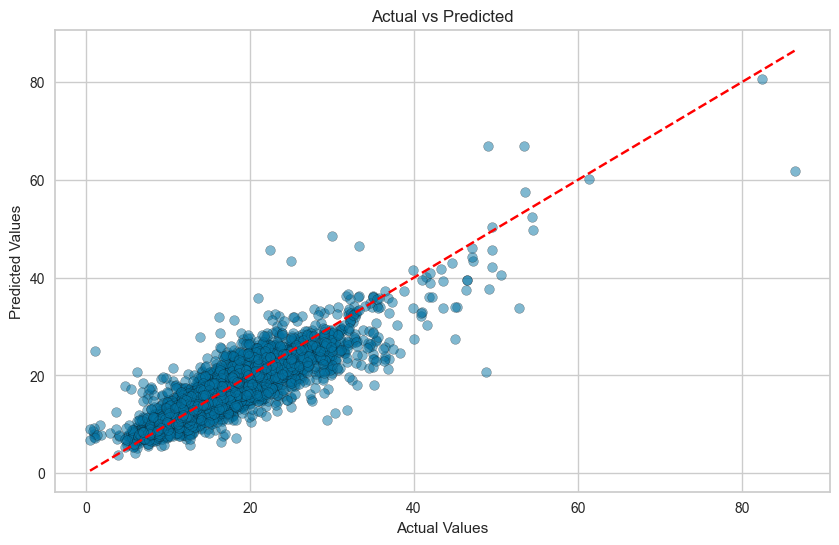

Search took 5.37 seconds.


In [237]:
# colums_to_drop_extended_priceM2 = colums_to_drop_extended.copy()
# colums_to_drop_extended_priceM2.append("priceM2")

# num_features = list(train.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=np.number).columns)
# cat_features = list(train.drop(columns=colums_to_drop_extended_priceM2).select_dtypes(include=['object']).columns)

# X_train = train.drop(columns=colums_to_drop_extended_priceM2)
# X_val = validation.drop(columns=colums_to_drop_extended_priceM2)
# X_test = test_map.drop(columns=colums_to_drop_extended_priceM2)

# y_train = train["priceM2"]
# y_val = validation["priceM2"]
# y_test = test_map["priceM2"]


# preprocessor = ColumnTransformer([
#     ("num", StandardScaler(), num_features),   # Standard Scaling for numerical features
#     ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)  # One-Hot Encoding for categorical features
# ])

# X_train_transformed = preprocessor.fit_transform(X_train)  # Fit & Transform training data
# X_val_transformed = preprocessor.fit_transform(X_val)  # Fit & Transform training data
# X_test_transformed = preprocessor.transform(X_test)        # Transform test data 


# Model instantiation
model = XGBRegressor(n_estimators=100, early_stopping_rounds=50)


model_name = "XGB"

# TIme counter
start = time.time()

# Parameter Grid
param_grid = {
    'n_estimators': [500],  # Number of boosting rounds (trees)
    # 'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    # 'max_depth': [-1, 20],  # Tree depth (-1 means no limit)
    # 'num_leaves': [30, 40],  # Maximum number of leaves per tree
    # 'min_child_samples': [30, 50],  # Minimum number of samples in a leaf
    # 'subsample': [0.6, 0.7, 0.8],  # Fraction of data used per iteration
    # 'colsample_bytree': [0.95, 1.0],  # Fraction of features used per iteration
    # 'reg_alpha': [0.05, 0.15, 0.1],  # L1 regularization
    # 'reg_lambda': [0.05, 0.1, 0.15]  # L2 regularization
}

nIter = 1 # Number of parameter settings to be sampled by RandomizedSearchCV

LGBM_reg, preds_LGBM_reg  = model_tuning(model, param_grid, model_name, nIter)
print(
    "Search took %.2f seconds."
    % ((time.time() - start))
)